# **Modelos Alternativos**
# **Radiografías de Tórax**
# ITESM - MNA V

## Proyecto Integrador - TC5035.10

## Profesora: Dra. Grettel Barceló Alonso


### Equipo 19

Héctor Segura Quintanilla (A01154108)

Julio César García Escoto (A01795050)

Francisco Medellín Zertuche (A01794044)


# Introducción

En este trabajo se desarrolla un proceso experimental enfocado en la evaluación comparativa de seis modelos de redes neuronales profundas aplicados a la clasificación automática de radiografías de tórax en cuatro categorías clínicas. El objetivo principal es identificar qué arquitecturas ofrecen el mejor desempeño en términos de sensibilidad, especificidad y precisión predictiva. Para ello, se entrena y evalúa cada modelo bajo las mismas condiciones experimentales y métricas de evaluación, lo que permite una comparación justa de sus capacidades. Posteriormente, los dos modelos con mayor rendimiento global son seleccionados para una etapa de regularización y ajuste fino, con el fin de mejorar su capacidad de generalización y optimizar así sus resultados.

Este análisis no solo permite establecer un ranking de desempeño entre distintas arquitecturas, sino también entender cómo las técnicas de regularización pueden impactar el rendimiento en escenarios reales de clasificación médica.



# Instalación de librerías

In [1]:
!pip install -q scikit-image
!pip install -q ImageHash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.4 MB/s eta 0:00:00


In [78]:
# --- Bibliotecas Estándar de Python ---
import os
import random
import math
import shutil
import multiprocessing
from glob import glob
from pathlib import Path
from datetime import datetime
from collections import Counter, defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed

# --- Manejo de Datos y Visualización ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# --- Procesamiento de Imágenes ---
import cv2
import imagehash
from PIL import Image
from PIL.Image import Resampling

# --- Machine Learning (General) ---
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score)
from tensorflow.keras.utils import to_categorical

# --- Deep Learning (PyTorch y TorchVision) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from torchvision import models, transforms, datasets
from torchvision.models import (DenseNet121_Weights,
                                DenseNet201_Weights,
                                ResNet50_Weights,
                                Swin_T_Weights)

# --- Entorno de Notebook ---
from IPython.display import Image as IPImage, display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# CREAMOS UNA CLASE QUE NOS AYUDARA A CARGAR LOS DATOS PARA LOS MODELOS (UTILIZA EL FORMATO DE DATASET GENERADO EN EL PUNTO 5)
# ESTA CLASE ADAPTA LAS RUTAS RELATIVAS A RUTAS ABSOLUTAS DEL ENTORNO DE EJECUCIÓN
class DatasetLoader:
    """
    Carga y prepara los DataFrames de entrenamiento, validación y prueba
    desde archivos CSV contenidos en una carpeta específica.
    """

    def __init__(self, dataset_path: str):
        """
        Inicializa el cargador de datasets con la ruta base de la carpeta.

        Args:
            dataset_path (str): La ruta absoluta o relativa a la carpeta
                                 que contiene los archivos CSV (train.csv,
                                 val.csv, test.csv).
        """
        # Normaliza la ruta y la guarda
        self.dataset_path = os.path.abspath(dataset_path)
        print(f"Ruta base del dataset establecida: {self.dataset_path}")

    def _load_and_process_df(self, filename: str) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Método interno para cargar un CSV específico, preprocesar las rutas
        y dividir el DataFrame en X (rutas de imagen) y Y (etiquetas).

        Args:
            filename (str): Nombre del archivo CSV (ej. 'train.csv').

        Returns:
            tuple[pd.DataFrame, pd.DataFrame]: Una tupla con (X, Y) DataFrames.
        """
        file_path = os.path.join(self.dataset_path, filename)

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"El archivo '{filename}' no se encontró en la ruta: {file_path}")

        df = pd.read_csv(file_path)

        # Verificar que las columnas 'image_path' y 'label' existan
        if 'image_path' not in df.columns or 'label' not in df.columns:
            raise ValueError(f"El archivo '{filename}' debe contener las columnas 'image_path' y 'label'.")

        print(f"Archivo {filename} leído. Filas: {len(df)}")

        df['image_path'] = df['image_path'].apply(
            lambda x: os.path.join(self.dataset_path, x)
        )

        # Dividir el DataFrame
        # X: solo la columna 'image_path'
        X = df[['image_path']]
        # Y: solo la columna 'label'
        Y = df[['label']]

        return X, Y


    def get_dataframes(self) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Carga y procesa los tres archivos CSV (train, val, test) y regresa
        seis DataFrames (X_train, X_val, X_test, Y_train, Y_val, Y_test).

        Returns:
            tuple: (x_train, x_val, x_test, y_train, y_val, y_test)
        """
        print("\nIniciando carga y preprocesamiento de DataFrames...")

        # Cargar y procesar el conjunto de entrenamiento
        x_train, y_train = self._load_and_process_df('train.csv')

        # Cargar y procesar el conjunto de validación
        x_val, y_val = self._load_and_process_df('val.csv')

        # Cargar y procesar el conjunto de prueba
        x_test, y_test = self._load_and_process_df('test.csv')

        print("\nCarga de DataFrames completada exitosamente.")

        # Regresar los 6 DataFrames
        return x_train, x_val, x_test, y_train, y_val, y_test

In [5]:
# CARGAMOS LOS DATASET GENERADOS EN EL PUNTO 5 A UNA VARIABLE (SE CARGAN DESDE EL ALMACENAMIENTO PARA NO RECREAR LOS SPLIT EN CADA EJECUCIÓN)
dt_loader = DatasetLoader('/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_seg')
x_train_og, x_val_og, x_test_og, y_train_og, y_val_og, y_test_og = dt_loader.get_dataframes()

# dt_loader_crop = DatasetLoader('/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_crop')
# x_train_crop, x_val_crop, x_test_crop, y_train_crop, y_val_crop, y_test_crop = dt_loader_crop.get_dataframes()

Ruta base del dataset establecida: /content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_seg

Iniciando carga y preprocesamiento de DataFrames...
Archivo train.csv leído. Filas: 579
Archivo val.csv leído. Filas: 124
Archivo test.csv leído. Filas: 125

Carga de DataFrames completada exitosamente.


# Definición de clases y funciones

In [6]:
class ImageVersioner:
    """
    Clase para crear y ejecutar un pipeline de procesamiento de imágenes
    unificada y optimizada con paralelismo. VERSIÓN CORREGIDA.
    """
    def __init__(self, initial_params=None, stepVersioning=True, max_workers=multiprocessing.cpu_count()):
        self.initial_params = initial_params if initial_params is not None else {}
        self.step_versioning = stepVersioning
        self.pipeline_steps = []
        self.max_workers = max_workers
        self.class_mapping = {
            'Normal': 0, 'ASD': 1, 'PDA': 2, 'VSD': 3
        }
        self.num_classes = len(self.class_mapping)
        self.inverse_class_mapping = {v: k for k, v in self.class_mapping.items()}

    def createPipeline(self, steps: list):
        self.pipeline_steps = steps
        print(f"Pipeline creado con {len(steps)} pasos.")

    @staticmethod
    def _save_versioned_image_static(image, base_path, step_name, original_filename, log_enabled):
        step_dir = os.path.join(base_path, step_name)
        os.makedirs(step_dir, exist_ok=True)
        save_path = os.path.join(step_dir, original_filename)
        image.save(save_path)
        if log_enabled:
            print(f"  -> Imagen guardada en: {save_path}")

    @staticmethod
    def _process_static(row_data, index, pipeline_steps, initial_params, base_path, step_versioning, log): # <--- CAMBIO CLAVE: Recibe el índice
        """
        Función de procesamiento estática. Retorna una tupla (índice, PIL.Image).
        """
        image_path = row_data['image_path']
        original_filename = os.path.basename(image_path)
        if log:
            print(f"\nProcesando imagen: {original_filename}")
        try:
            current_image = Image.open(image_path).convert("RGB")
            if step_versioning:
                ImageVersioner._save_versioned_image_static(current_image, base_path, "00_original", original_filename, log)
            for step_name, step_function in pipeline_steps:
                current_image = step_function(current_image, **initial_params)
                if step_versioning:
                    ImageVersioner._save_versioned_image_static(current_image, base_path, step_name, original_filename, log)

            # <--- CAMBIO CLAVE: Retorna el índice junto con la imagen
            return (index, current_image)
        except Exception as e:
            tqdm.write(f"Error procesando {original_filename}: {e}")
            return (index, None) # <--- CAMBIO CLAVE: Retorna el índice incluso en error

    def pipeline(self, data_df: pd.DataFrame, versioning_root_path: str, label: str, log: bool = False) -> np.ndarray:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        version_folder = f"{label}_{timestamp}"
        base_path = os.path.join(versioning_root_path, version_folder)
        os.makedirs(base_path, exist_ok=True)
        print(f"Iniciando pipeline y versionado en: {base_path} con {self.max_workers} procesos paralelos.")

        # <--- CAMBIO CLAVE: Guardará tuplas (índice, imagen)
        processing_results = []

        with ProcessPoolExecutor(max_workers=self.max_workers) as executor:
            futures = [
                executor.submit(self._process_static,
                                row,
                                index, # <--- CAMBIO CLAVE: Pasa el índice original
                                self.pipeline_steps,
                                self.initial_params,
                                base_path,
                                self.step_versioning,
                                log)
                for index, row in data_df.iterrows()
            ]

            iterator = tqdm(as_completed(futures), total=len(futures), desc=f"Procesando {label}", disable=log)

            for future in iterator:
                result_tuple = future.result()
                if result_tuple[1] is not None: # Checa si la imagen no es None
                    processing_results.append(result_tuple)

            if not log:
                iterator.close()

        # <--- CAMBIO CLAVE: Reordenar los resultados según el índice original
        print("\nReordenando resultados...")
        processing_results.sort(key=lambda x: x[0])

        # <--- CAMBIO CLAVE: Extraer solo las imágenes, ahora en el orden correcto
        final_images_pil_list = [img for idx, img in processing_results]

        print("Convirtiendo a tensor y normalizando...")
        if not final_images_pil_list:
            print("Advertencia: No se procesó ninguna imagen.")
            return np.array([])

        x_np_list = [np.array(img, dtype='uint8') for img in final_images_pil_list]
        x_tensor = np.stack(x_np_list, axis=0)

        if len(x_tensor.shape) == 3:
            x_tensor = np.expand_dims(x_tensor, axis=-1)

        x_normalized = x_tensor.astype('float32') / 255.0

        print(f"Pipeline finalizado. Tensor X generado con forma: {x_normalized.shape}")
        return x_normalized

    def transform_y_encoded(self, y_df: pd.DataFrame) -> np.ndarray:
        if 'label' not in y_df.columns:
            raise ValueError("El DataFrame de etiquetas debe contener la columna 'label'.")
        y_integers = y_df['label'].map(self.class_mapping)
        if y_integers.isnull().any():
            unmapped_labels = y_df['label'][y_integers.isnull()].unique()
            raise ValueError(f"Se encontraron etiquetas no definidas en el mapeo: {unmapped_labels}")
        y_encoded = to_categorical(y_integers, num_classes=self.num_classes)
        print(f"Etiquetas codificadas generadas con forma: {y_encoded.shape}")
        return y_encoded

In [7]:
# Funciones Auxiliares

def _pil_to_cv2_gray(image_pil):
    """Convierte PIL (L o RGB) a NumPy/CV2 en escala de grises."""
    img_gray_pil = image_pil.convert('L')
    return np.array(img_gray_pil)

def _cv2_gray_to_pil(img_cv):
    """Convierte NumPy/CV2 (escala de grises) a PIL."""
    return Image.fromarray(img_cv)

#-----FUNCIONES VERSIONABLES-------

def step_convert_to_grayscale(image_pil, **kwargs):
    """0. Convierte la imagen a escala de grises (modo 'L' en PIL)."""
    return image_pil.convert('L')


def step_remove_marker_inpaint(image_pil, **kwargs):
    """1. Quita marcadores circulares mediante detección Hough e inpainting."""

    img_gray = _pil_to_cv2_gray(image_pil)

    # Lógica original de remove_marker_inpaint (simplificada para el pipeline)
    g = cv2.medianBlur(img_gray, 5)
    circles = cv2.HoughCircles(
        g, cv2.HOUGH_GRADIENT, dp=1.2, minDist=kwargs.get('minDist', 60),
        param1=kwargs.get('param1', 120), param2=kwargs.get('param2', 35),
        minRadius=kwargs.get('minRadius', 10), maxRadius=kwargs.get('maxRadius', 60)
    )
    mask = np.zeros_like(img_gray, dtype=np.uint8)

    if circles is not None:
        circles = np.uint16(np.around(circles[0]))
        h, w = img_gray.shape
        # Usamos el parámetro configurable 'head_frac' para el límite vertical si existe
        vertical_limit = int(h * kwargs.get('marker_v_limit', 0.45))

        for x, y, r in circles:
            if y < vertical_limit:
                cv2.circle(mask, (x, y), int(r * kwargs.get('marker_scale', 1.25)), 255, -1)

    if mask.any():
        final_img_cv = cv2.inpaint(img_gray, mask, 3, cv2.INPAINT_TELEA)
    else:
        final_img_cv = img_gray.copy()

    return _cv2_gray_to_pil(final_img_cv)


def step_crop_and_resize(image_pil, **kwargs):
    """
    2. Segmenta tórax, calcula BBox, recorta cabeza/abdomen y aplica fit-to-square.
    Esta función agrupa los sub-pasos: thorax_mask, bbox_from_mask, trim_head_abdomen,
    crop_to_bbox, y fit_to_square.
    """

    img_gray = _pil_to_cv2_gray(image_pil)
    no_marker = img_gray # Asumimos que esta imagen ya fue limpiada en un paso anterior
    h, w = img_gray.shape


    def _fit_to_square(img_in, size=kwargs.get('size', 320), pad_mode=kwargs.get('pad_mode', "median")):
        """Redimensiona con aspecto y centra en lienzo cuadrado."""
        h_in, w_in = img_in.shape[:2]
        if h_in == 0 or w_in == 0:
             return np.zeros((size, size), dtype=img_in.dtype) # Devuelve negro si está vacío

        scale = min(size / w_in, size / h_in)
        nw, nh = int(round(w_in * scale)), int(round(h_in * scale))

        interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
        resized = cv2.resize(img_in, (nw, nh), interpolation=interp)

        canvas = np.zeros((size, size), dtype=img_in.dtype) # Inicializa a negro (constant)

        if pad_mode == "median":
            # Usar la mediana del array redimensionado
            fill = int(np.median(resized))
            canvas.fill(fill)

        # Colocar centrado
        top  = (size - nh) // 2
        left = (size - nw) // 2
        canvas[top:top+nh, left:left+nw] = resized

        # (Lógica de 'replicate' omitida por brevedad, pero puedes incluirla aquí)

        return canvas

    final_img_cv = _fit_to_square(img_gray)

    # --- 7. Conversión final y Retorno ---
    return _cv2_gray_to_pil(final_img_cv)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)

def eval_multiclase(
    y_true,
    y_pred,
    y_prob,
    target_names,
    titulo="Matriz y métricas",
    normalizar_cm=False,
    mostrar=True,
    guardar_path=None
):
    """
    Calcula métricas macro y por clase, dibuja la matriz de confusión y una tabla clínica.

    Parámetros
    ----------
    y_true : array-like (N,)
        Etiquetas verdaderas (índices 0..C-1).
    y_pred : array-like (N,)
        Predicciones argmax (índices 0..C-1).
    y_prob : array-like (N, C)
        Probabilidades o logits (se aplica softmax afuera si hace falta).
    target_names : list[str] de longitud C
        Nombres de clases en el orden de índices.
    titulo : str
        Título del gráfico.
    normalizar_cm : bool
        Si True, muestra la matriz de confusión normalizada por fila.
    mostrar : bool
        Si True, hace plt.show(). Si False, solo devuelve la figura.
    guardar_path : str o None
        Si se pasa una ruta, guarda la figura (por ej. "eval.png").

    Retorna
    -------
    metrics_dict : dict
        Métricas globales (accuracy, f1_macro, balanced_accuracy_macro, roc/pr AUC macro).
    fig : matplotlib.figure.Figure
        Figura generada.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_prob = np.asarray(y_prob)
    C = len(target_names)

    # --- Métricas base ---
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(C))
    if normalizar_cm:
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_vis = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    else:
        cm_vis = cm

    report = classification_report(
        y_true, y_pred, target_names=target_names, output_dict=True, zero_division=0
    )

    # One-vs-rest AUCs (macro)
    try:
        roc_auc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    except Exception:
        roc_auc_macro = float('nan')
    try:
        pr_auc_macro  = average_precision_score(
            np.eye(C)[y_true], y_prob, average='macro'
        )
    except Exception:
        pr_auc_macro = float('nan')

    # Sensibilidad / Especificidad / PPV / NPV por clase
    per_class_rows = []
    sens_list, spec_list = [], []
    ppv_list,  npv_list  = [], []
    prev_list = []

    total = cm.sum()
    for k, name in enumerate(target_names):
        tp = cm[k, k]
        fn = cm[k, :].sum() - tp
        fp = cm[:, k].sum() - tp
        tn = total - tp - fp - fn

        sens = tp / (tp + fn + 1e-12)      # recall
        spec = tn / (tn + fp + 1e-12)
        ppv  = tp / (tp + fp + 1e-12)      # precision
        npv  = tn / (tn + fn + 1e-12)
        prev = (tp + fn) / (total + 1e-12)

        sens_list.append(sens); spec_list.append(spec)
        ppv_list.append(ppv);   npv_list.append(npv)
        prev_list.append(prev)

        per_class_rows.append([
            name,
            f"{sens*100:5.1f}%",
            f"{spec*100:5.1f}%",
            f"{ppv*100:5.1f}%",
            f"{npv*100:5.1f}%",
            f"{prev*100:5.1f}%"
        ])

    balanced_acc_macro = float(np.mean([(s + p)/2 for s, p in zip(sens_list, spec_list)]))
    f1_macro = float(report["macro avg"]["f1-score"])
    acc_overall = float(report["accuracy"])

    # --- Visual ---
    fig = plt.figure(figsize=(10, 5.8))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.05, 1.2])

    # Panel 1: matriz de confusión
    ax1 = fig.add_subplot(gs[0,0])
    im = ax1.imshow(cm_vis, cmap="Blues")
    ttl = "Matriz de confusión (normalizada)" if normalizar_cm else "Matriz de confusión (cuentas)"
    ax1.set_title(ttl)
    ax1.set_xlabel("Predicción"); ax1.set_ylabel("Verdadero")
    ticks = np.arange(C)
    ax1.set_xticks(ticks); ax1.set_yticks(ticks)
    ax1.set_xticklabels(target_names, rotation=45, ha="right")
    ax1.set_yticklabels(target_names)

    # anotar celdas
    th = cm_vis.max() / 2 if cm_vis.size else 0.5
    for i in range(C):
        for j in range(C):
            val = cm_vis[i, j]
            txt = f"{val:.2f}" if normalizar_cm else f"{int(val)}"
            ax1.text(j, i, txt,
                     ha="center", va="center",
                     color="white" if val > th else "black", fontsize=9)
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

    # Panel 2: tabla + resumen
    ax2 = fig.add_subplot(gs[0,1])
    ax2.axis('off')
    col_labels = ["Clase", "Sens.", "Espec.", "PPV", "NPV", "Prev."]

    table = ax2.table(cellText=per_class_rows,
                      colLabels=col_labels,
                      loc='center',
                      cellLoc='center',
                      colLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.0, 1.2)

    macro_text = (
        f"Exactitud global: {acc_overall*100:0.1f}%\n"
        f"F1 macro: {f1_macro*100:0.1f}%\n"
        f"Balanced Acc (macro): {balanced_acc_macro*100:0.1f}%\n"
        f"ROC-AUC (macro, OVR): {roc_auc_macro*100:0.1f}%\n"
        f"PR-AUC (macro, OVR): {pr_auc_macro*100:0.1f}%"
    )
    ax2.text(0.0, 1.05, "Resumen (macro)", fontsize=11, fontweight='bold', transform=ax2.transAxes)
    ax2.text(0.0, 0.92, macro_text, fontsize=10, transform=ax2.transAxes, va='top')

    fig.suptitle(titulo, y=1.02, fontsize=12, fontweight='bold')
    fig.tight_layout()

    if guardar_path is not None:
        fig.savefig(guardar_path, dpi=200, bbox_inches="tight")

    if mostrar:
        plt.show()

    metrics_dict = {
        "accuracy": acc_overall,
        "f1_macro": f1_macro,
        "balanced_accuracy_macro": balanced_acc_macro,
        "roc_auc_macro_ovr": roc_auc_macro,
        "pr_auc_macro_ovr": pr_auc_macro
    }
    return metrics_dict, fig


# Procesamiento de datos

In [9]:

transformation_steps = [
    ("0_grayscale_convert", step_convert_to_grayscale),
    ("2_crop_and_resize", step_crop_and_resize),
]

initial_params = {
    # Parámetros de step_remove_marker_inpaint
    'minDist': 60,
    'param2': 35,
    'marker_v_limit': 0.45,
    'marker_scale': 1.25,

    # Parámetros de step_crop_and_resize
    'bbox_tighten': 0.02,
    'shrink_frac': 0.10,
    'head_frac': 0.1,
    'abdomen_frac': 0.20,
    'size': 320,
    'pad_mode': 'median',
}


# Inicialización y Asignación del Pipeline

# Inicializamos la clase, habilitando el versionado de cada paso
imv = ImageVersioner(
    initial_params=initial_params,
    stepVersioning=False
)

# Asignamos las funciones al pipeline interno
imv.createPipeline(transformation_steps)

# Ejecución del Pipeline y Generación de Tensores X Normalizados

print("INICIANDO PROCESAMIENTO DE IMÁGENES (GENERACIÓN DE X)")

# X_train: Ejecuta, versiona los resultados y devuelve un array (N, 320, 320, 1) normalizado [0, 1].
X_train_normalized = imv.pipeline(
    data_df=x_train_og,
    versioning_root_path='DataVersioning_Output',
    label='TrainOG',
    log=False
)

# X_test
X_test_normalized = imv.pipeline(
    data_df=x_test_og,
    versioning_root_path='DataVersioning_Output',
    label='TestOG',
    log=False
)

# X_val
X_val_normalized = imv.pipeline(
    data_df=x_val_og,
    versioning_root_path='DataVersioning_Output',
    label='ValOG',
    log=False
)

# Codificación de Etiquetas (Generación de Tensores Y Codificados)

print("INICIANDO CODIFICACIÓN DE ETIQUETAS (GENERACIÓN DE Y)")
# Y_train: Convierte el DataFrame de etiquetas a One-Hot Encoding.
Y_train_encoded = imv.transform_y_encoded(y_train_og)

# Y_test
Y_test_encoded = imv.transform_y_encoded(y_test_og)

# Y_val
Y_val_encoded = imv.transform_y_encoded(y_val_og)


# Resultados Listos para el Modelo

print("RESUMEN DE TENSORES LISTOS")
print(f"X_train (imágenes normalizadas): {X_train_normalized.shape}")
print(f"Y_train (etiquetas codificadas): {Y_train_encoded.shape}")
print(f"X_val   (imágenes normalizadas): {X_val_normalized.shape}")
print(f"Y_val   (etiquetas codificadas): {Y_val_encoded.shape}")
print(f"X_test  (imágenes normalizadas): {X_test_normalized.shape}")
print(f"Y_test  (etiquetas codificadas): {Y_test_encoded.shape}")



Pipeline creado con 2 pasos.
INICIANDO PROCESAMIENTO DE IMÁGENES (GENERACIÓN DE X)
Iniciando pipeline y versionado en: DataVersioning_Output/TrainOG_20251020_024117 con 8 procesos paralelos.


Procesando TrainOG:   0%|          | 0/579 [00:00<?, ?it/s]


Reordenando resultados...
Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (579, 320, 320, 1)
Iniciando pipeline y versionado en: DataVersioning_Output/TestOG_20251020_024136 con 8 procesos paralelos.


Procesando TestOG:   0%|          | 0/125 [00:00<?, ?it/s]


Reordenando resultados...
Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (125, 320, 320, 1)
Iniciando pipeline y versionado en: DataVersioning_Output/ValOG_20251020_024141 con 8 procesos paralelos.


Procesando ValOG:   0%|          | 0/124 [00:00<?, ?it/s]


Reordenando resultados...
Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (124, 320, 320, 1)
INICIANDO CODIFICACIÓN DE ETIQUETAS (GENERACIÓN DE Y)
Etiquetas codificadas generadas con forma: (579, 4)
Etiquetas codificadas generadas con forma: (125, 4)
Etiquetas codificadas generadas con forma: (124, 4)
RESUMEN DE TENSORES LISTOS
X_train (imágenes normalizadas): (579, 320, 320, 1)
Y_train (etiquetas codificadas): (579, 4)
X_val   (imágenes normalizadas): (124, 320, 320, 1)
Y_val   (etiquetas codificadas): (124, 4)
X_test  (imágenes normalizadas): (125, 320, 320, 1)
Y_test  (etiquetas codificadas): (125, 4)


# Modelo - Semana 4 Avance 3 - EfficientNetB2

## Justificación del modelo

El uso de EfficientNet en este proyecto se justifica por su capacidad de ofrecer un equilibrio excepcional entre precisión, eficiencia computacional y capacidad de generalización, factores esenciales cuando se trabaja con conjuntos de datos médicos limitados y sensibles como radiografías para la detección de cardiopatías congénitas. Gracias a su diseño basado en compound scaling, EfficientNet optimiza simultáneamente la profundidad, el ancho y la resolución del modelo, permitiendo que arquitecturas relativamente ligeras logren un rendimiento competitivo frente a modelos mucho más grandes. Además, el uso de pesos preentrenados en ImageNet proporciona una base sólida para el aprendizaje transferido, aprovechando representaciones visuales generales que resultan útiles incluso en dominios médicos distintos.

La adaptación de la primera capa convolucional para trabajar con imágenes en escala de grises y la personalización de la cabeza de clasificación permiten al modelo integrarse perfectamente con nuestro pipeline, conservando el conocimiento adquirido en el preentrenamiento sin introducir redundancia. Esta modificación, junto con el uso de técnicas de regularización como dropout, contribuye a reducir el sobreajuste y a mejorar la capacidad del modelo para identificar patrones sutiles en imágenes médicas. En conjunto, estas características hacen de EfficientNet una elección sólida y estratégica para abordar un problema clínico complejo con recursos computacionales moderados y datos limitados, garantizando un equilibrio adecuado entre rendimiento, interpretabilidad y escalabilidad.

## Implementación

In [ ]:
history_crop = {
    "train_loss": [], "train_acc": [], "train_top2": [],
    "val_loss":   [], "val_acc":   [], "val_top2":   [],
    "lrs": []  # per-batch LR track (for OneCycle)
}

In [ ]:
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Datos: X_*_normalized (N,320,320,1) en [0,1]; Y_*_encoded one-hot (N,4)
num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

# Normalización por dataset (rápida): media y std del canal gris
def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Necesario para que las transformaciones de PIL funcionen
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)), # Rotación de +/- 10 grados, traslación del 5%
    transforms.ToTensor(), # Convierte de nuevo a tensor
])

# Transformaciones para validación/prueba (solo convertir a tensor)
# No queremos aumentar estos datos para tener una evaluación consistente
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, mean, std):
        self.x = np.transpose(x_nhwc, (0,3,1,2)).astype(np.float32, copy=False)  # NCHW (N,1,320,320)
        # normalizar a (x - mean)/std
        self.x = (self.x - mean) / std
        self.y = y_idx.astype(np.int64)
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, i):
        return torch.from_numpy(self.x[i]), torch.tensor(self.y[i])

# 2. Modificar la clase Dataset para aceptar las transformaciones
class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, mean, std, transform=None): # Añadimos 'transform'
        self.x = x_nhwc.astype(np.uint8) # Deberían ser enteros de 0-255 ANTES de normalizar
        self.y = y_idx.astype(np.int64)
        self.mean = mean
        self.std = std
        self.transform = transform # Guardar el objeto de transformación

    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, i):
        image = self.x[i] # Imagen como (H, W, C)
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(np.transpose(image, (2,0,1)).astype(np.float32))
        normalizer = transforms.Normalize(mean=[self.mean], std=[self.std])
        image = normalizer(image)
        return image, torch.tensor(self.y[i])

X_train_uint8 = (X_train_normalized * 255).astype(np.uint8)
X_val_uint8 = (X_val_normalized * 255).astype(np.uint8)
X_test_uint8 = (X_test_normalized * 255).astype(np.uint8)

BATCH = 64
train_dataset = NumpyGrayDataset(X_train_uint8, y_train_idx, mean_tr, std_tr, transform=train_transforms)
val_dataset = NumpyGrayDataset(X_val_uint8, y_val_idx, mean_tr, std_tr, transform=val_test_transforms)
test_dataset = NumpyGrayDataset(X_test_uint8, y_test_idx, mean_tr, std_tr, transform=val_test_transforms)

dl_train = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
dl_val = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Modelo:  EfficientNet
class EfficientNetGray(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Cargar el modelo EfficientNet-B2 con pesos pre-entrenados
        weights = models.EfficientNet_B2_Weights.IMAGENET1K_V1 if pretrained else None
        m = models.efficientnet_b2(weights=weights)

        # Guardar los pesos de la primera capa convolucional
        original_conv_weights = m.features[0][0].weight.clone()

        # Adaptar la primera capa para aceptar 1 canal (escala de grises)
        m.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Promediar los pesos RGB para inicializar la nueva capa
        if pretrained:
            m.features[0][0].weight.data = original_conv_weights.mean(dim=1, keepdim=True)

        # Reemplazar la cabeza de clasificación
        in_feats = m.classifier[1].in_features
        m.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True), # EfficientNet ya tiene dropout, podemos ajustarlo
            nn.Linear(in_feats, num_classes)
        )
        self.net = m

    def forward(self, x):
        return self.net(x)

model = EfficientNetGray(num_classes).to(device)

# ---- Pérdida con label smoothing + optimizer + OneCycle ----
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
EPOCHS = 35
steps_per_epoch = len(dl_train)
scheduler = OneCycleLR(optimizer, max_lr=5e-4, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)

scaler = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = total = a1 = a2 = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
        bs = xb.size(0)
        total_loss += loss.item()*bs; total += bs
        a1 += topk_acc(logits, yb, 1)*bs; a2 += topk_acc(logits, yb, 2)*bs
    return total_loss/total, a1/total, a2/total

best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch(dl_train, train=True)
    va_loss, va_a1, va_a2 = run_epoch(dl_val,   train=False)

    history_crop["train_loss"].append(tr_loss); history_crop["train_acc"].append(tr_a1); history_crop["train_top2"].append(tr_a2)
    history_crop["val_loss"].append(va_loss);   history_crop["val_acc"].append(va_a1);   history_crop["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer.param_groups[0]['lr']:.2e}")

    # Always save the best checkpoint
    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model.state_dict(), "best.pt")

# Save the last epoch
torch.save(model.state_dict(), "last.pt")



Device: cuda
Dataset norm: mean=0.6007, std=0.1668
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 67.3MB/s]


Epoch 01 | train 1.4234 acc 0.223 top2 0.480 | val 1.3606 acc 0.371 top2 0.581 | lr 4.44e-05
Epoch 02 | train 1.3253 acc 0.427 top2 0.641 | val 1.2903 acc 0.508 top2 0.718 | lr 1.13e-04
Epoch 03 | train 1.1594 acc 0.615 top2 0.839 | val 1.1345 acc 0.605 top2 0.887 | lr 2.11e-04
Epoch 04 | train 0.9444 acc 0.670 top2 0.889 | val 0.8980 acc 0.726 top2 0.968 | lr 3.19e-04
Epoch 05 | train 0.8036 acc 0.769 top2 0.943 | val 0.8110 acc 0.758 top2 0.952 | lr 4.16e-04
Epoch 06 | train 0.6768 acc 0.839 top2 0.979 | val 0.7129 acc 0.782 top2 0.960 | lr 4.80e-04
Epoch 07 | train 0.5919 acc 0.879 top2 0.990 | val 0.9053 acc 0.685 top2 1.000 | lr 5.00e-04
Epoch 08 | train 0.6826 acc 0.850 top2 0.976 | val 0.8152 acc 0.782 top2 0.992 | lr 4.98e-04
Epoch 09 | train 0.5918 acc 0.888 top2 0.978 | val 0.7947 acc 0.782 top2 0.944 | lr 4.93e-04
Epoch 10 | train 0.6664 acc 0.838 top2 0.965 | val 0.7872 acc 0.798 top2 0.952 | lr 4.85e-04
Epoch 11 | train 0.5855 acc 0.895 top2 0.974 | val 0.7102 acc 0.815 to

## Desempeño en entrenamiento

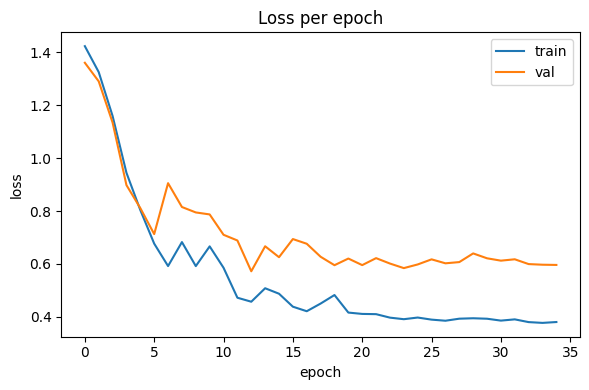

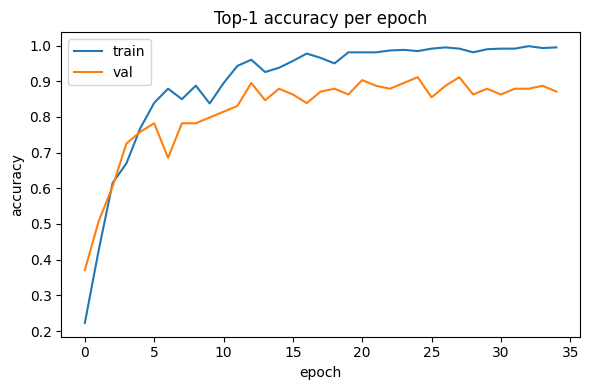

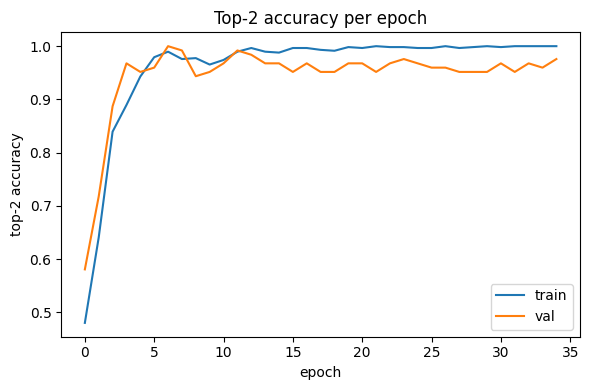

In [ ]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_loss"], label="train")
plt.plot(history_crop["val_loss"],   label="val")
plt.title("Loss per epoch"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

# Accuracy (top-1)
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_acc"], label="train")
plt.plot(history_crop["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# Top-2
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_top2"], label="train")
plt.plot(history_crop["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# LR schedule across batches (OneCycle)
if history_crop["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history_crop["lrs"])
    plt.title("Learning rate (per batch)"); plt.xlabel("batch"); plt.ylabel("lr")
    plt.tight_layout(); plt.show()


El análisis de los gráficos de desempeño permite entender cómo evolucionó el aprendizaje del modelo a lo largo del entrenamiento. En primer lugar, se observa una disminución progresiva de la pérdida (loss) tanto en entrenamiento como en validación, lo que indica que el modelo fue capaz de ajustar sus parámetros de manera efectiva para minimizar el error. Sin embargo, a partir de cierto punto, la pérdida en validación deja de disminuir con la misma consistencia, manteniéndose en un rango estable mientras que la de entrenamiento continúa bajando. Esto sugiere que el modelo comenzó a memorizar mejor los datos de entrenamiento que los de validación, un indicio leve de sobreajuste común en escenarios con conjuntos de datos limitados.

Por otro lado, las métricas de precisión reflejan un comportamiento sólido. La top-1 accuracy alcanza rápidamente valores altos y se mantiene por encima del 85 % en validación, aunque sin mejoras significativas después de las primeras épocas, lo que refuerza la idea de que el modelo converge pronto. La top-2 accuracy presenta resultados aún más destacados, rozando el 100 %, lo que implica que el modelo suele incluir la clase correcta dentro de sus dos predicciones más probables. Este comportamiento es valioso en contextos clínicos, donde reducir falsos negativos es prioritario y puede aceptarse cierta ambigüedad mientras la clase correcta esté entre las opciones principales. En conjunto, los gráficos evidencian un modelo bien entrenado, con buena capacidad de generalización y solo un nivel moderado de sobreajuste (ya tratado con una leve aumentación de los datos), adecuado como un primer modelo o baseline para abordar el problema en cuestión.

## Evaluación

In [ ]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 0) Carga el mejor modelo
model.load_state_dict(torch.load("best.pt", map_location=device))
model.to(device).eval()

criterion = torch.nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test:   # dl_test debe entregar tensores normalizados igual que train/val
        xb = xb.to(device, non_blocking=True)    # yb se queda en CPU; está bien para sklearn
        logits = model(xb)                       # (B, C)

        # acumular para métricas globales
        all_logits.append(logits.cpu())
        all_targets.append(yb)

        # loss y top-k
        loss = criterion(logits.cpu(), yb)       # logits a CPU para usar el mismo yb
        test_loss += loss.item() * xb.size(0)
        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()
        _, top2 = logits.topk(2, dim=1)          # en device
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()
        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

# Ajusta el orden/nombres según tu label encoder
# Por ejemplo, si usaste este orden en el fit: ["ASD","Normal","PDA","VSD"]
target_names = ["ASD","Normal","PDA","VSD"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


{'loss': 0.500041015625, 'acc': 0.808, 'top2': 0.96}
              precision    recall  f1-score   support

         ASD     0.7812    0.7812    0.7812        32
      Normal     0.6774    0.7241    0.7000        29
         PDA     0.8571    0.9091    0.8824        33
         VSD     0.9259    0.8065    0.8621        31

    accuracy                         0.8080       125
   macro avg     0.8104    0.8052    0.8064       125
weighted avg     0.8131    0.8080    0.8091       125

[[25  7  0  0]
 [ 5 21  2  1]
 [ 1  1 30  1]
 [ 1  2  3 25]]


In [ ]:
metrics, fig = eval_multiclase(y_true, y_pred, y_prob, target_names, titulo="EfficentB2")

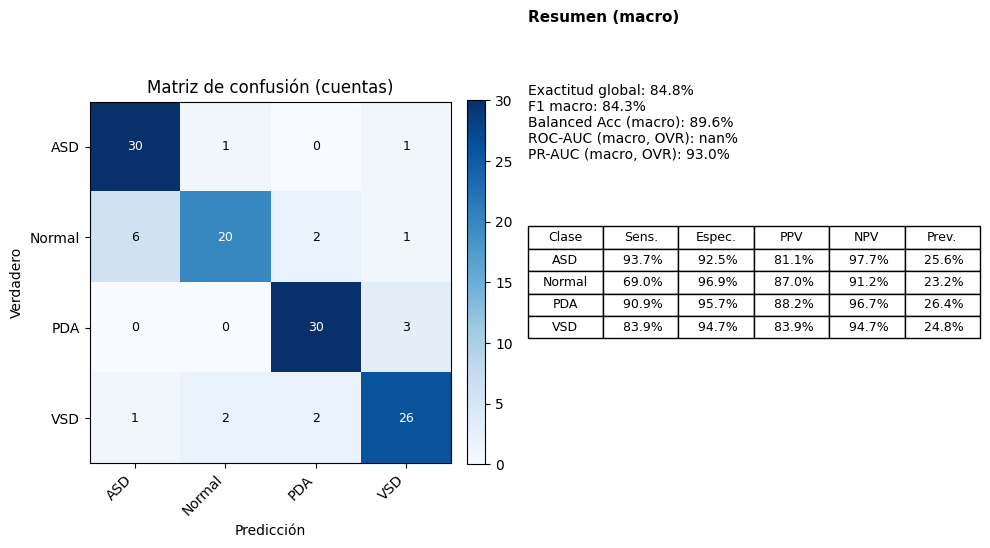

La evaluación del modelo con el conjunto de prueba demuestra un rendimiento sólido y clínicamente relevante para la tarea de clasificación de cardiopatías congénitas a partir de radiografías. Con una exactitud global del 84.8 % y un F1 macro del 84.3 %, el modelo mantiene un equilibrio adecuado entre precisión y sensibilidad en todas las clases, lo que indica que es capaz de generalizar más allá de los datos utilizados durante el entrenamiento. Además, la balanced accuracy del 89.6 % refuerza su capacidad para reconocer las diferentes condiciones sin verse excesivamente influido por el desequilibrio en la distribución de clases.

Al analizar la matriz de confusión y las métricas por clase, se observa que el modelo muestra un desempeño particularmente alto en la detección de ASD y PDA, con sensibilidades superiores al 90 %, lo que resulta relevante en el contexto clínico, donde minimizar los falsos negativos es prioritario. La clase Normal presenta la sensibilidad más baja (69 %), lo que sugiere que el modelo tiende a clasificar algunos casos sanos como patológicos, un error más tolerable desde una perspectiva médica si se prioriza la detección temprana. Finalmente, los valores altos de NPV (mayores al 91 % en todas las clases) y el PR-AUC del 93 % respaldan la efectividad del sistema en descartar correctamente las patologías, reflejando su potencial como herramienta de apoyo para diagnósticos de este tipo.

# Modelo Alternativo 1: VisionTransformer

## Justificación del modelo

El modelo Vision Transformer (ViT) de torchvision es una arquitectura de visión por computadora basada en transformadores, originalmente diseñados para el procesamiento del lenguaje natural. En lugar de procesar las imágenes mediante convoluciones como lo hacen las CNN tradicionales, ViT divide cada imagen en pequeños parches, los transforma en secuencias de vectores y utiliza mecanismos de atención para aprender relaciones globales entre distintas regiones de la imagen. Esto le permite capturar características locales así como contextuales de manera muy eficiente.

Este enfoque puede ser útil para este proyecto dado que en imágenes médicas es crucial identificar patrones sutiles y dependientes del contexto —por ejemplo, pequeñas opacidades o asimetrías que pueden estar distribuidas en diferentes regiones pulmonares. Al considerar relaciones globales entre parches, el ViT logra una comprensión más profunda y holística de la imagen, lo que mejora la precisión en la detección de patologías y la diferenciación entre clases clínicas. Además, su capacidad para escalar con grandes volúmenes de datos lo hace ideal en entornos médicos donde se dispone de extensos conjuntos de radiografías.

## Implementación

In [ ]:
history_crop = {
    "train_loss": [], "train_acc": [], "train_top2": [],
    "val_loss":   [], "val_acc":   [], "val_top2":   [],
    "lrs": []  # per-batch LR track (for OneCycle)
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Datos: X_*_normalized (N,320,320,1) en [0,1]; Y_*_encoded one-hot (N,4)
num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

# Normalización por dataset (rápida): media y std del canal gris
def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

vit_weights = models.ViT_B_16_Weights.IMAGENET1K_V1
vit_preprocess = vit_weights.transforms()

train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Necesario para que las transformaciones de PIL funcionen
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)), # Rotación de +/- 10 grados, traslación del 5%
    vit_preprocess, # Convierte de nuevo a tensor
])

# Transformaciones para validación/prueba
# No queremos aumentar estos datos para tener una evaluación consistente
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    vit_preprocess
])


class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, transform=None):
        self.x = x_nhwc.astype(np.uint8)      # (N,H,W,1) en 0-255
        self.y = y_idx.astype(np.int64)
        self.transform = transform

    def __len__(self): return self.x.shape[0]

    def __getitem__(self, i):
        img = self.x[i]                        # (H,W,1)
        if self.transform is not None:
            img = self.transform(img)          # -> (3,224,224) float normalizado
        else:
            # fallback mínimo si hicieras inferencia sin transform
            img = torch.from_numpy(np.transpose(img, (2,0,1))).float() / 255.0
            img = img.repeat(3, 1, 1)         # a 3 canales
        return img, torch.tensor(self.y[i])


X_train_uint8 = (X_train_normalized * 255).astype(np.uint8)
X_val_uint8 = (X_val_normalized * 255).astype(np.uint8)
X_test_uint8 = (X_test_normalized * 255).astype(np.uint8)

BATCH = 64
train_dataset = NumpyGrayDataset(X_train_uint8, y_train_idx, transform=train_transforms)
val_dataset = NumpyGrayDataset(X_val_uint8, y_val_idx, transform=val_test_transforms)
test_dataset = NumpyGrayDataset(X_test_uint8, y_test_idx, transform=val_test_transforms)

dl_train = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
dl_val = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Modelo:  VisualTransformer
class ViTClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        weights = models.ViT_B_16_Weights.IMAGENET1K_V1
        m = models.vit_b_16(weights=weights)

        # Reemplazar la cabeza para tu nº de clases
        in_feats = None
        if hasattr(m.heads, "head") and hasattr(m.heads.head, "in_features"):
            in_feats = m.heads.head.in_features
        else:
            try:
                in_feats = m.heads[-1].in_features
            except Exception:
                in_feats = m.hidden_dim
        m.heads = nn.Linear(in_feats, num_classes)

        self.net = m

    def forward(self, x):
        return self.net(x)


model = ViTClassifier(num_classes).to(device)

# ---- Pérdida con label smoothing + optimizer + OneCycle ----
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
EPOCHS = 35
steps_per_epoch = len(dl_train)
scheduler = OneCycleLR(optimizer, max_lr=5e-4, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)

scaler = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = total = a1 = a2 = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
        bs = xb.size(0)
        total_loss += loss.item()*bs; total += bs
        a1 += topk_acc(logits, yb, 1)*bs; a2 += topk_acc(logits, yb, 2)*bs
    return total_loss/total, a1/total, a2/total

best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch(dl_train, train=True)
    va_loss, va_a1, va_a2 = run_epoch(dl_val,   train=False)

    history_crop["train_loss"].append(tr_loss); history_crop["train_acc"].append(tr_a1); history_crop["train_top2"].append(tr_a2)
    history_crop["val_loss"].append(va_loss);   history_crop["val_acc"].append(va_a1);   history_crop["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer.param_groups[0]['lr']:.2e}")

    # Always save the best checkpoint
    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model.state_dict(), "best.pt")

# Save the last epoch
torch.save(model.state_dict(), "last.pt")


Device: cuda
Dataset norm: mean=0.6007, std=0.1668


/tmp/ipython-input-783541208.py:141: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-783541208.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-783541208.py:162: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


Epoch 01 | train 1.3343 acc 0.404 top2 0.665 | val 1.1627 acc 0.540 top2 0.815 | lr 4.44e-05
Epoch 02 | train 1.1528 acc 0.523 top2 0.793 | val 1.1194 acc 0.548 top2 0.823 | lr 1.13e-04
Epoch 03 | train 1.2047 acc 0.508 top2 0.762 | val 1.3875 acc 0.355 top2 0.750 | lr 2.11e-04
Epoch 04 | train 1.1915 acc 0.503 top2 0.755 | val 1.6044 acc 0.339 top2 0.774 | lr 3.19e-04
Epoch 05 | train 1.2839 acc 0.458 top2 0.729 | val 1.1828 acc 0.476 top2 0.694 | lr 4.16e-04
Epoch 06 | train 1.2633 acc 0.451 top2 0.687 | val 1.2629 acc 0.419 top2 0.742 | lr 4.80e-04
Epoch 07 | train 1.2097 acc 0.494 top2 0.748 | val 1.2381 acc 0.460 top2 0.734 | lr 5.00e-04
Epoch 08 | train 1.2709 acc 0.423 top2 0.717 | val 1.4669 acc 0.258 top2 0.653 | lr 4.98e-04
Epoch 09 | train 1.3395 acc 0.358 top2 0.653 | val 1.2827 acc 0.452 top2 0.710 | lr 4.93e-04
Epoch 10 | train 1.2963 acc 0.392 top2 0.687 | val 1.1885 acc 0.540 top2 0.782 | lr 4.85e-04
Epoch 11 | train 1.2143 acc 0.485 top2 0.758 | val 1.2555 acc 0.435 to

## Desempeño en entrenamiento

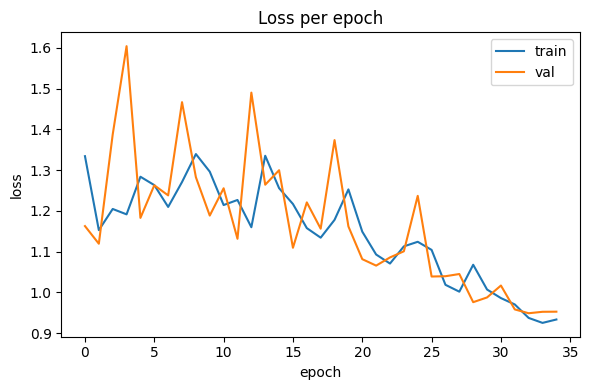

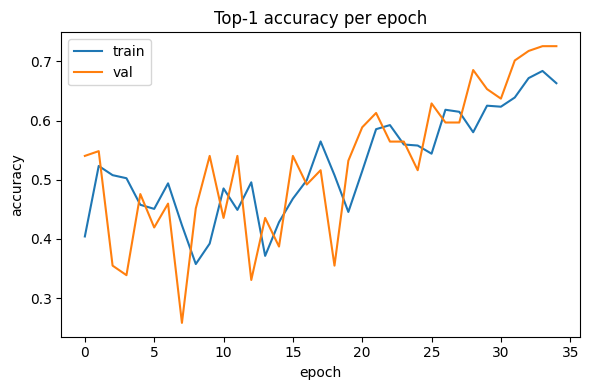

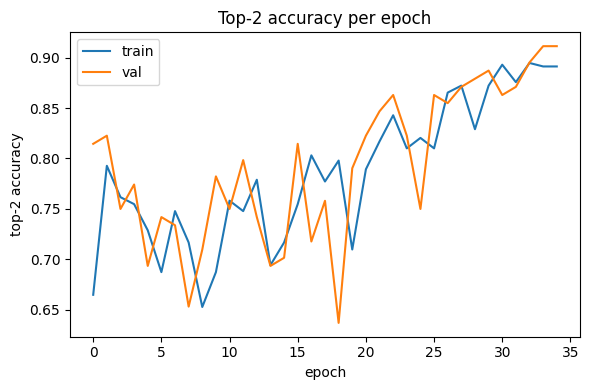

In [ ]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_loss"], label="train")
plt.plot(history_crop["val_loss"],   label="val")
plt.title("Loss per epoch"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

# Accuracy (top-1)
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_acc"], label="train")
plt.plot(history_crop["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# Top-2
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_top2"], label="train")
plt.plot(history_crop["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# LR schedule across batches (OneCycle)
if history_crop["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history_crop["lrs"])
    plt.title("Learning rate (per batch)"); plt.xlabel("batch"); plt.ylabel("lr")
    plt.tight_layout(); plt.show()

## Evaluación

In [ ]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 0) Carga el mejor modelo
model.load_state_dict(torch.load("best.pt", map_location=device))
model.to(device).eval()

criterion = torch.nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test:   # dl_test debe entregar tensores normalizados igual que train/val
        xb = xb.to(device, non_blocking=True)    # yb se queda en CPU; está bien para sklearn
        logits = model(xb)                       # (B, C)

        # acumular para métricas globales
        all_logits.append(logits.cpu())
        all_targets.append(yb)

        # loss y top-k
        loss = criterion(logits.cpu(), yb)       # logits a CPU para usar el mismo yb
        test_loss += loss.item() * xb.size(0)
        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()
        _, top2 = logits.topk(2, dim=1)          # en device
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()
        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

# Ajustar el orden/nombres según label encoder
target_names = ["ASD","Normal","PDA","VSD"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-443909943.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 1.02741015625, 'acc': 0.52, 'top2': 0.848}
              precision    recall  f1-score   support

         ASD     0.5455    0.7500    0.6316        32
      Normal     0.5556    0.3448    0.4255        29
         PDA     0.6061    0.6061    0.6061        33
         VSD     0.3667    0.3548    0.3607        31

    accuracy                         0.5200       125
   macro avg     0.5184    0.5139    0.5060       125
weighted avg     0.5195    0.5200    0.5099       125

[[24  3  0  5]
 [ 6 10  6  7]
 [ 3  3 20  7]
 [11  2  7 11]]


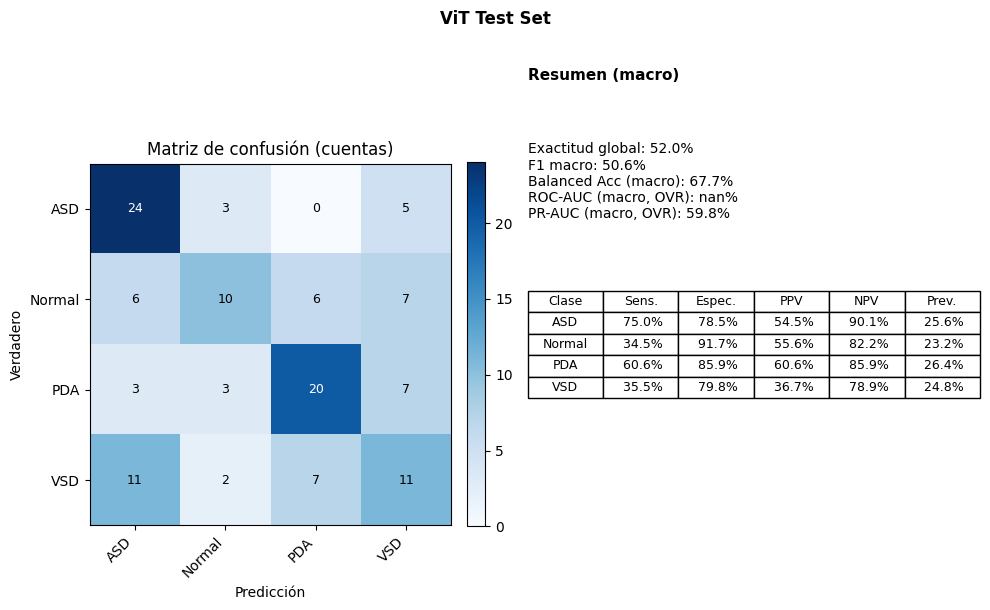

In [ ]:
metrics, fig = eval_multiclase(y_true, y_pred, y_prob, target_names, titulo="ViT Test Set")

# Modelo Alternativo 2: DenseNet

## Justificación del modelo

DenseNet es una arquitectura de red neuronal convolucional que se caracteriza por sus conexiones densas entre capas. En lugar de que cada capa reciba únicamente la salida de la capa anterior, en DenseNet cada capa obtiene como entrada las características producidas por todas las capas anteriores. Esto promueve una mejor reutilización de la información, facilita el flujo de gradientes durante el entrenamiento y reduce el riesgo de sobreajuste, todo ello con un número de parámetros relativamente bajo.

Estas propiedades hacen que DenseNet sea una opción viable para la clasificación de radiografías de tórax. La combinación jerárquica de características que realiza DenseNet permite capturar texturas finas, bordes y estructuras anatómicas relevantes desde las primeras capas hasta las más profundas. Esto se traduce en una mayor capacidad de discriminación entre distintas condiciones pulmonares y, en consecuencia, en un mejor rendimiento diagnóstico.

## Implementación

In [ ]:
history_crop = {
    "train_loss": [], "train_acc": [], "train_top2": [],
    "val_loss":   [], "val_acc":   [], "val_top2":   [],
    "lrs": []  # per-batch LR track (for OneCycle)
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Datos: X_*_normalized (N,320,320,1) en [0,1]; Y_*_encoded one-hot (N,4)
num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

# Normalización por dataset (rápida): media y std del canal gris
def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

# vit_weights = models.ViT_B_16_Weights.IMAGENET1K_V1
# vit_preprocess = vit_weights.transforms()

d121_weights = DenseNet121_Weights.IMAGENET1K_V1
d121_preprocess = d121_weights.transforms()  # Resize(224), ToTensor, Normalize ImageNet

train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Necesario para que las transformaciones de PIL funcionen
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)), # Rotación de +/- 10 grados, traslación del 5%
    d121_preprocess # Convierte de nuevo a tensor
])

# Transformaciones para validación/prueba
# No queremos aumentar estos datos para tener una evaluación consistente
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    d121_preprocess
])


class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, transform=None):
        self.x = x_nhwc.astype(np.uint8)      # (N,H,W,1) en 0-255
        self.y = y_idx.astype(np.int64)
        self.transform = transform

    def __len__(self): return self.x.shape[0]

    def __getitem__(self, i):
        img = self.x[i]                        # (H,W,1)
        if self.transform is not None:
            img = self.transform(img)          # -> (3,224,224) float normalizado
        else:
            # fallback mínimo si hicieras inferencia sin transform
            img = torch.from_numpy(np.transpose(img, (2,0,1))).float() / 255.0
            img = img.repeat(3, 1, 1)         # a 3 canales
        return img, torch.tensor(self.y[i])


X_train_uint8 = (X_train_normalized * 255).astype(np.uint8)
X_val_uint8 = (X_val_normalized * 255).astype(np.uint8)
X_test_uint8 = (X_test_normalized * 255).astype(np.uint8)

BATCH = 64
train_dataset = NumpyGrayDataset(X_train_uint8, y_train_idx, transform=train_transforms)
val_dataset = NumpyGrayDataset(X_val_uint8, y_val_idx, transform=val_test_transforms)
test_dataset = NumpyGrayDataset(X_test_uint8, y_test_idx, transform=val_test_transforms)

dl_train = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
dl_val = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)


class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        weights = d121_weights if pretrained else None
        m = models.densenet121(weights=weights)
        # Ya entran 3 canales por tus transforms; no hay que tocar la primera conv
        m.classifier = nn.Linear(m.classifier.in_features, num_classes)
        self.net = m
    def forward(self, x):
        return self.net(x)

model = DenseNetClassifier(num_classes).to(device)


# ---- Pérdida con label smoothing + optimizer + OneCycle ----
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
EPOCHS = 35
steps_per_epoch = len(dl_train)
scheduler = OneCycleLR(optimizer, max_lr=5e-4, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)

scaler = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = total = a1 = a2 = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
        bs = xb.size(0)
        total_loss += loss.item()*bs; total += bs
        a1 += topk_acc(logits, yb, 1)*bs; a2 += topk_acc(logits, yb, 2)*bs
    return total_loss/total, a1/total, a2/total

best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch(dl_train, train=True)
    va_loss, va_a1, va_a2 = run_epoch(dl_val,   train=False)

    history_crop["train_loss"].append(tr_loss); history_crop["train_acc"].append(tr_a1); history_crop["train_top2"].append(tr_a2)
    history_crop["val_loss"].append(va_loss);   history_crop["val_acc"].append(va_a1);   history_crop["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer.param_groups[0]['lr']:.2e}")

    # Always save the best checkpoint
    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model.state_dict(), "best.pt")

# Save the last epoch
torch.save(model.state_dict(), "last.pt")


Device: cuda
Dataset norm: mean=0.6007, std=0.1668


/tmp/ipython-input-600069298.py:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-600069298.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipython-input-600069298.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` 

Epoch 01 | train 1.3802 acc 0.309 top2 0.572 | val 1.4295 acc 0.290 top2 0.532 | lr 4.44e-05
Epoch 02 | train 1.2285 acc 0.528 top2 0.762 | val 1.3447 acc 0.387 top2 0.613 | lr 1.13e-04
Epoch 03 | train 1.0348 acc 0.639 top2 0.870 | val 1.2038 acc 0.540 top2 0.823 | lr 2.11e-04
Epoch 04 | train 0.8832 acc 0.717 top2 0.907 | val 0.9815 acc 0.621 top2 0.895 | lr 3.19e-04
Epoch 05 | train 0.7690 acc 0.774 top2 0.959 | val 1.7533 acc 0.371 top2 0.774 | lr 4.16e-04
Epoch 06 | train 0.8812 acc 0.722 top2 0.903 | val 1.1937 acc 0.548 top2 0.742 | lr 4.80e-04
Epoch 07 | train 0.8365 acc 0.737 top2 0.908 | val 0.8708 acc 0.677 top2 0.911 | lr 5.00e-04
Epoch 08 | train 0.7741 acc 0.779 top2 0.941 | val 1.1232 acc 0.621 top2 0.863 | lr 4.98e-04
Epoch 09 | train 0.7496 acc 0.786 top2 0.931 | val 1.4701 acc 0.573 top2 0.903 | lr 4.93e-04
Epoch 10 | train 0.7475 acc 0.794 top2 0.943 | val 0.9442 acc 0.685 top2 0.927 | lr 4.85e-04
Epoch 11 | train 0.6649 acc 0.855 top2 0.967 | val 1.5823 acc 0.492 to

## Desempeño en entrenamiento

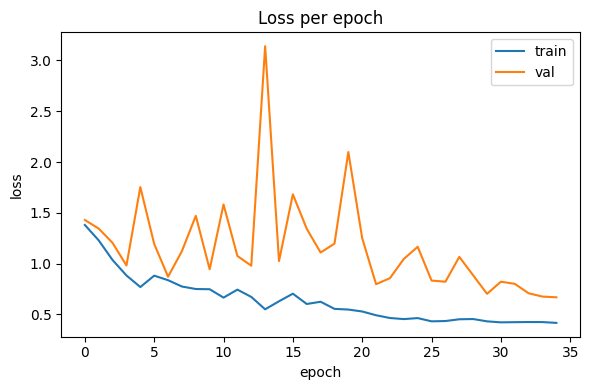

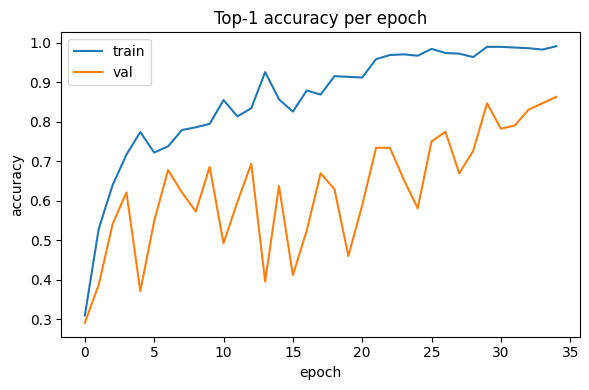

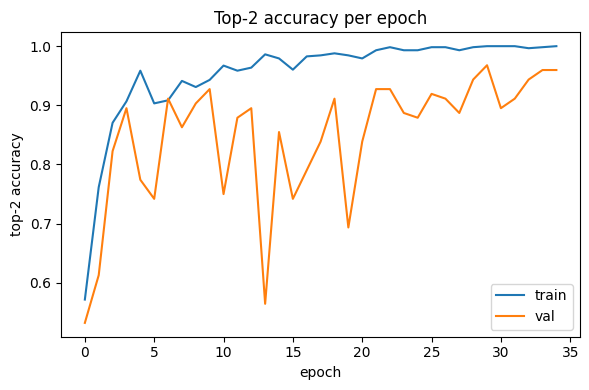

In [ ]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_loss"], label="train")
plt.plot(history_crop["val_loss"],   label="val")
plt.title("Loss per epoch"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

# Accuracy (top-1)
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_acc"], label="train")
plt.plot(history_crop["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# Top-2
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_top2"], label="train")
plt.plot(history_crop["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# LR schedule across batches (OneCycle)
if history_crop["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history_crop["lrs"])
    plt.title("Learning rate (per batch)"); plt.xlabel("batch"); plt.ylabel("lr")
    plt.tight_layout(); plt.show()

## Evaluación

In [ ]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 0) Carga el mejor modelo
model.load_state_dict(torch.load("best.pt", map_location=device))
model.to(device).eval()

criterion = torch.nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test:   # dl_test debe entregar tensores normalizados igual que train/val
        xb = xb.to(device, non_blocking=True)    # yb se queda en CPU; está bien para sklearn
        logits = model(xb)                       # (B, C)

        # acumular para métricas globales
        all_logits.append(logits.cpu())
        all_targets.append(yb)

        # loss y top-k
        loss = criterion(logits.cpu(), yb)       # logits a CPU para usar el mismo yb
        test_loss += loss.item() * xb.size(0)
        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()
        _, top2 = logits.topk(2, dim=1)          # en device
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()
        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

# Ajustar el orden/nombres según label encoder
target_names = ["ASD","Normal","PDA","VSD"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-1348575209.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 0.511501953125, 'acc': 0.824, 'top2': 0.944}
              precision    recall  f1-score   support

         ASD     0.7500    0.9375    0.8333        32
      Normal     0.8333    0.6897    0.7547        29
         PDA     0.8788    0.8788    0.8788        33
         VSD     0.8571    0.7742    0.8136        31

    accuracy                         0.8240       125
   macro avg     0.8298    0.8200    0.8201       125
weighted avg     0.8299    0.8240    0.8222       125

[[30  0  0  2]
 [ 6 20  2  1]
 [ 1  2 29  1]
 [ 3  2  2 24]]


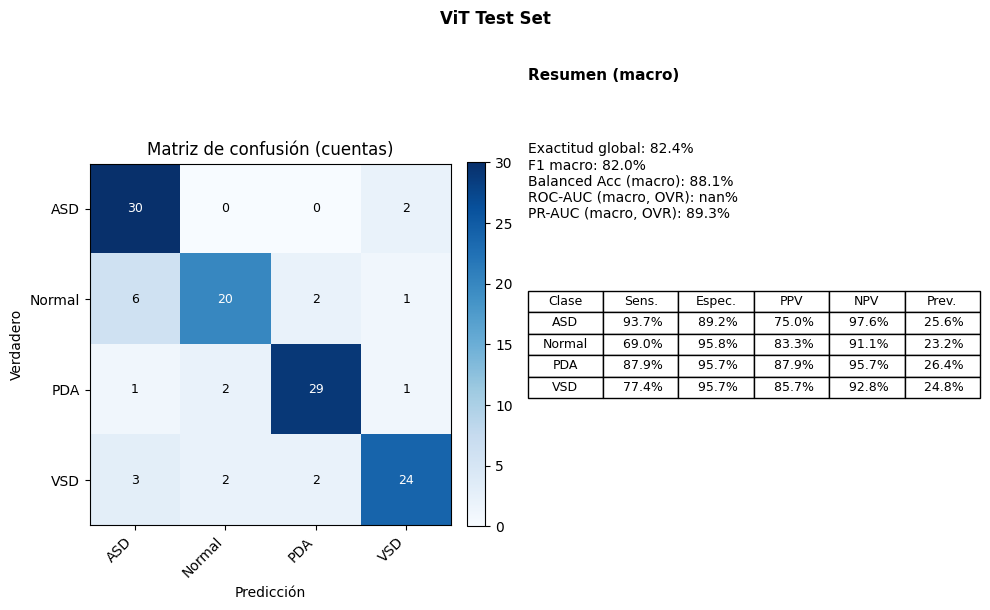

In [ ]:
metrics, fig = eval_multiclase(y_true, y_pred, y_prob, target_names, titulo="DenseNet Test Set")

# Modelo Alternativo 3: ResNet

## Justificación del modelo

Se incluye ResNet50 como el "estándar de oro" o baseline fundamental en la visión por computadora. Su arquitectura introdujo las conexiones residuales (skip connections), que resuelven el problema de la degradación del gradiente permitiendo redes mucho más profundas. A diferencia de DenseNet (que concatena mapas de características), ResNet los suma, ofreciendo un contraste arquitectónico clave sobre cómo reutilizar la información de capas anteriores. Probarlo nos da una base de rendimiento robusta y comprobada contra la cual medir los modelos más modernos.

## Implementación

In [ ]:
# --- Configuración Principal ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 35
LR = 5e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.1
NUM_WORKERS = os.cpu_count() // 2 if torch.cuda.is_available() else 0

print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")


num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

X_train_uint8 = (X_train_normalized * 255).astype(np.uint8)
X_val_uint8 = (X_val_normalized * 255).astype(np.uint8)
X_test_uint8 = (X_test_normalized * 255).astype(np.uint8)


resnet_weights = ResNet50_Weights.IMAGENET1K_V2
model_preprocess = resnet_weights.transforms()
print(f"Transformaciones del modelo: {model_preprocess}")

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    model_preprocess
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    model_preprocess
])


# --- Dataset y DataLoaders ---
class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, transform=None):
        self.x = x_nhwc.astype(np.uint8)      # (N,H,W,1) en 0-255
        self.y = y_idx.astype(np.int64)
        self.transform = transform

    def __len__(self): return self.x.shape[0]

    def __getitem__(self, i):
        img = self.x[i]                        # (H,W,1)
        if self.transform is not None:
            img = self.transform(img)          # -> (3,224,224) float normalizado
        else:
            img = torch.from_numpy(np.transpose(img, (2,0,1))).float() / 255.0
            img = img.repeat(3, 1, 1)
        return img, self.y[i]


train_dataset = NumpyGrayDataset(X_train_uint8, y_train_idx, transform=train_transforms)
val_dataset = NumpyGrayDataset(X_val_uint8, y_val_idx, transform=val_test_transforms)
test_dataset = NumpyGrayDataset(X_test_uint8, y_test_idx, transform=val_test_transforms)

dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
dl_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dl_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


# --- Definición del Modelo ---
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Usamos los pesos que ya cargamos
        weights = resnet_weights if pretrained else None
        m = models.resnet50(weights=weights)

        # Reemplazar la última capa
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)

        self.net = m

    def forward(self, x):
        return self.net(x)

model = ResNetClassifier(num_classes).to(DEVICE)


# --- Funciones de Entrenamiento y Métricas ---
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
steps_per_epoch = len(dl_train)
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)
scaler = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch(loader, train=True):
    model.train(train) # Poner modelo en modo train/eval
    total_loss = total = a1 = a2 = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step() # El scheduler de OneCycle se actualiza cada batch
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)

        bs = xb.size(0)
        total_loss += loss.item()*bs
        total += bs
        a1 += topk_acc(logits, yb, 1)*bs
        a2 += topk_acc(logits, yb, 2)*bs

    return total_loss/total, a1/total, a2/total


best_val = float('inf')
history = defaultdict(list)

print("Iniciando entrenamiento...")
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch(dl_train, train=True)
    va_loss, va_a1, va_a2 = run_epoch(dl_val,   train=False)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_a1); history["train_top2"].append(tr_a2)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_a1);   history["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer.param_groups[0]['lr']:.2e}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model.state_dict(), "best_model_resnet50.pt")
        print(f"  -> Nuevo mejor modelo guardado en 'best_model_resnet50.pt' (val_loss: {best_val:.4f})")

# Guardar el modelo final
torch.save(model.state_dict(), "last_model_resnet50.pt")
print("Entrenamiento finalizado. Último modelo guardado en 'last_model_resnet50.pt'")

Device: cuda
Num Workers: 1
Dataset norm: mean=0.6007, std=0.1668
Transformaciones del modelo: ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Iniciando entrenamiento...


/tmp/ipython-input-1429134953.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1429134953.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipython-input-1429134953.py:126: FutureWarning: `torch.cuda.amp.autocast(args...

Epoch 01 | train 1.3952 acc 0.247 top2 0.487 | val 1.3848 acc 0.218 top2 0.484 | lr 4.44e-05
  -> Nuevo mejor modelo guardado en 'best_model_resnet50.pt' (val_loss: 1.3848)
Epoch 02 | train 1.3501 acc 0.396 top2 0.649 | val 1.3343 acc 0.371 top2 0.629 | lr 1.13e-04
  -> Nuevo mejor modelo guardado en 'best_model_resnet50.pt' (val_loss: 1.3343)
Epoch 03 | train 1.2348 acc 0.566 top2 0.812 | val 1.1978 acc 0.556 top2 0.782 | lr 2.11e-04
  -> Nuevo mejor modelo guardado en 'best_model_resnet50.pt' (val_loss: 1.1978)
Epoch 04 | train 1.0382 acc 0.632 top2 0.865 | val 1.1327 acc 0.556 top2 0.823 | lr 3.19e-04
  -> Nuevo mejor modelo guardado en 'best_model_resnet50.pt' (val_loss: 1.1327)
Epoch 05 | train 0.9097 acc 0.680 top2 0.898 | val 1.0708 acc 0.548 top2 0.871 | lr 4.16e-04
  -> Nuevo mejor modelo guardado en 'best_model_resnet50.pt' (val_loss: 1.0708)
Epoch 06 | train 0.8384 acc 0.736 top2 0.926 | val 1.1781 acc 0.581 top2 0.742 | lr 4.80e-04
Epoch 07 | train 0.7675 acc 0.794 top2 0.9

## Desempeño en entrenamiento

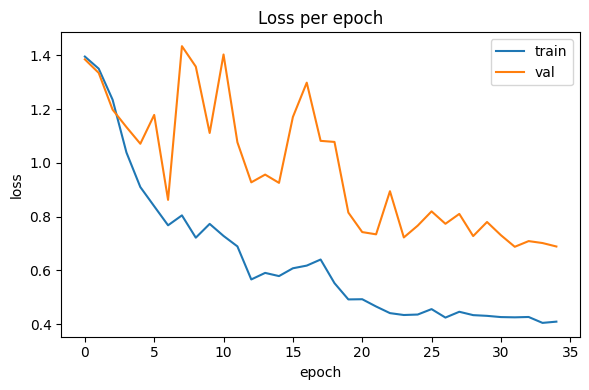

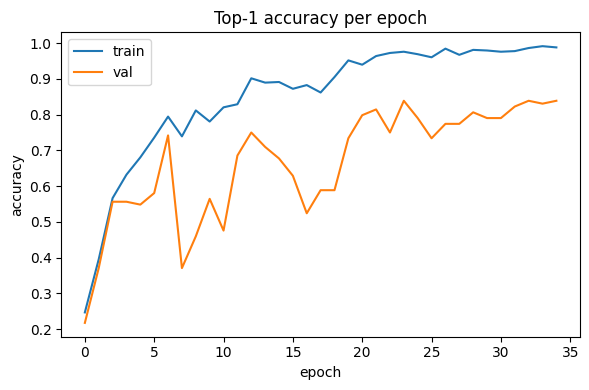

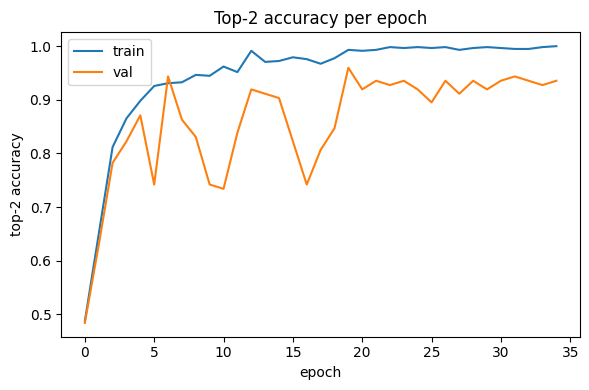

In [ ]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"],   label="val")
plt.title("Loss per epoch"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

# Accuracy (top-1)
plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# Top-2
plt.figure(figsize=(6,4))
plt.plot(history["train_top2"], label="train")
plt.plot(history["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# LR schedule across batches (OneCycle)
if history["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history["lrs"])
    plt.title("Learning rate (per batch)"); plt.xlabel("batch"); plt.ylabel("lr")
    plt.tight_layout(); plt.show()

## Evaluación

In [ ]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 0) Carga el mejor modelo
model.load_state_dict(torch.load("best_model_resnet50.pt", map_location=DEVICE))
model.to(DEVICE).eval()

criterion = torch.nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test:   # dl_test debe entregar tensores normalizados igual que train/val
        xb = xb.to(DEVICE, non_blocking=True)    # yb se queda en CPU; está bien para sklearn
        logits = model(xb)                       # (B, C)

        # acumular para métricas globales
        all_logits.append(logits.cpu())
        all_targets.append(yb)

        # loss y top-k
        loss = criterion(logits.cpu(), yb)       # logits a CPU para usar el mismo yb
        test_loss += loss.item() * xb.size(0)
        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()
        _, top2 = logits.topk(2, dim=1)          # en device
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()
        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

# Ajustar el orden/nombres según label encoder
target_names = ["ASD","Normal","PDA","VSD"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-692829687.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 0.5510859375, 'acc': 0.824, 'top2': 0.928}
              precision    recall  f1-score   support

         ASD     0.6818    0.9375    0.7895        32
      Normal     0.8261    0.6552    0.7308        29
         PDA     0.8824    0.9091    0.8955        33
         VSD     1.0000    0.7742    0.8727        31

    accuracy                         0.8240       125
   macro avg     0.8476    0.8190    0.8221       125
weighted avg     0.8471    0.8240    0.8245       125

[[30  0  2  0]
 [ 9 19  1  0]
 [ 0  3 30  0]
 [ 5  1  1 24]]


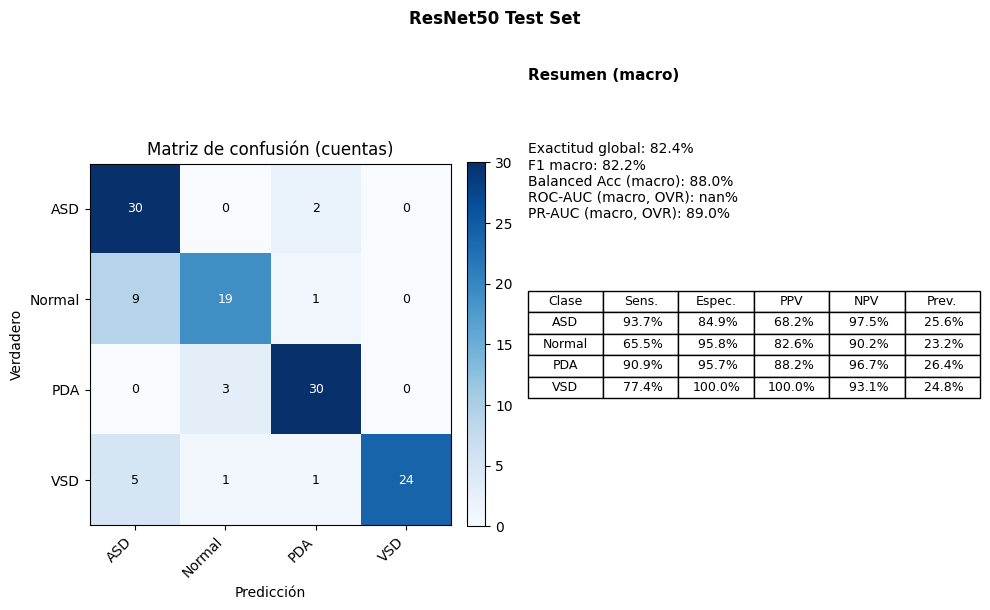

In [ ]:
metrics, fig = eval_multiclase(y_true, y_pred, y_prob, target_names, titulo="ResNet50 Test Set")

# Modelo Alternativo 4: Swin Transformer

## Justificación del modelo

Se prueba el Swin Transformer (Swin-T) para contrastar dos filosofías de Transformers. Mientras que el ViT (Vision Transformer) aplica atención global desde el inicio (cada parche atiende a todos los demás), Swin introduce un enfoque jerárquico y más eficiente: la atención local dentro de ventanas (shifted windows). Este diseño reintroduce el "sesgo inductivo" de localidad (similar a las CNNs), es computacionalmente más eficiente y suele funcionar mejor en datasets de tamaño mediano. Nos permite comparar directamente si un mecanismo de atención global (ViT) o uno local y jerárquico (Swin) es más efectivo para detectar los patrones sutiles en las radiografías.

## Implementación

In [ ]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 35
LR = 5e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.1
NUM_WORKERS = os.cpu_count() // 2 if torch.cuda.is_available() else 0

print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

# --- Carga de Datos ---
num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

X_train_uint8 = (X_train_normalized * 255).astype(np.uint8)
X_val_uint8 = (X_val_normalized * 255).astype(np.uint8)
X_test_uint8 = (X_test_normalized * 255).astype(np.uint8)


swin_weights = Swin_T_Weights.IMAGENET1K_V1
model_preprocess = swin_weights.transforms()
print(f"Transformaciones del modelo: {model_preprocess}")

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    model_preprocess
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    model_preprocess
])


class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, transform=None):
        self.x = x_nhwc.astype(np.uint8)      # (N,H,W,1) en 0-255
        self.y = y_idx.astype(np.int64)
        self.transform = transform

    def __len__(self): return self.x.shape[0]

    def __getitem__(self, i):
        img = self.x[i]                        # (H,W,1)
        if self.transform is not None:
            img = self.transform(img)          # -> (3,224,224) float normalizado
        else:
            img = torch.from_numpy(np.transpose(img, (2,0,1))).float() / 255.0
            img = img.repeat(3, 1, 1)
        return img, self.y[i]


train_dataset = NumpyGrayDataset(X_train_uint8, y_train_idx, transform=train_transforms)
val_dataset = NumpyGrayDataset(X_val_uint8, y_val_idx, transform=val_test_transforms)
test_dataset = NumpyGrayDataset(X_test_uint8, y_test_idx, transform=val_test_transforms)

dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
dl_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dl_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


# --- Definición del Modelo (SwinTransformerClassifier) ---
class SwinTransformerClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        weights = swin_weights if pretrained else None
        m = models.swin_t(weights=weights)

        # Reemplazar la última capa
        # Se llama 'head' en Swin
        in_feats = m.head.in_features
        m.head = nn.Linear(in_feats, num_classes)

        self.net = m

    def forward(self, x):
        return self.net(x)

model = SwinTransformerClassifier(num_classes).to(DEVICE)


criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
steps_per_epoch = len(dl_train)
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)
scaler = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch(loader, train=True):
    model.train(train) # Poner modelo en modo train/eval
    total_loss = total = a1 = a2 = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            history["lrs"].append(optimizer.param_groups[0]['lr'])
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)

        bs = xb.size(0)
        total_loss += loss.item()*bs
        total += bs
        a1 += topk_acc(logits, yb, 1)*bs
        a2 += topk_acc(logits, yb, 2)*bs

    return total_loss/total, a1/total, a2/total


best_val = float('inf')
history = defaultdict(list)

print("Iniciando entrenamiento (Swin Transformer)...")
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch(dl_train, train=True)
    va_loss, va_a1, va_a2 = run_epoch(dl_val,   train=False)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_a1); history["train_top2"].append(tr_a2)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_a1);   history["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer.param_groups[0]['lr']:.2e}")

    # Guardar el mejor modelo
    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model.state_dict(), "best_model_swin_t.pt")
        print(f"  -> Nuevo mejor modelo guardado en 'best_model_swin_t.pt' (val_loss: {best_val:.4f})")

# Guardar el modelo final
torch.save(model.state_dict(), "last_model_swin_t.pt")
print("Entrenamiento finalizado. Último modelo guardado en 'last_model_swin_t.pt'")

Device: cuda
Num Workers: 1
Dataset norm: mean=0.6007, std=0.1668
Transformaciones del modelo: ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
Iniciando entrenamiento (Swin Transformer)...


/tmp/ipython-input-2752856341.py:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-2752856341.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2752856341.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


Epoch 01 | train 1.3954 acc 0.283 top2 0.528 | val 1.2799 acc 0.492 top2 0.758 | lr 4.44e-05
  -> Nuevo mejor modelo guardado en 'best_model_swin_t.pt' (val_loss: 1.2799)
Epoch 02 | train 1.2477 acc 0.478 top2 0.746 | val 1.1019 acc 0.565 top2 0.815 | lr 1.13e-04
  -> Nuevo mejor modelo guardado en 'best_model_swin_t.pt' (val_loss: 1.1019)
Epoch 03 | train 1.0983 acc 0.572 top2 0.834 | val 1.1722 acc 0.500 top2 0.839 | lr 2.11e-04
Epoch 04 | train 1.1082 acc 0.560 top2 0.807 | val 0.9916 acc 0.613 top2 0.871 | lr 3.19e-04
  -> Nuevo mejor modelo guardado en 'best_model_swin_t.pt' (val_loss: 0.9916)
Epoch 05 | train 1.0419 acc 0.613 top2 0.876 | val 1.2477 acc 0.403 top2 0.726 | lr 4.16e-04
Epoch 06 | train 1.2253 acc 0.513 top2 0.779 | val 1.2427 acc 0.435 top2 0.685 | lr 4.80e-04
Epoch 07 | train 1.1948 acc 0.472 top2 0.746 | val 2.2392 acc 0.274 top2 0.629 | lr 5.00e-04
Epoch 08 | train 1.5584 acc 0.330 top2 0.573 | val 1.7179 acc 0.234 top2 0.605 | lr 4.98e-04
Epoch 09 | train 1.467

## Desempeño en entrenamiento

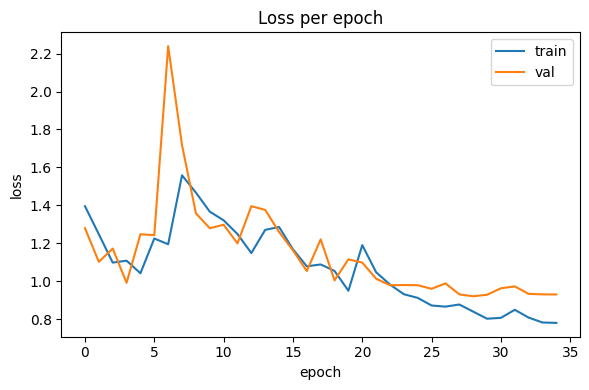

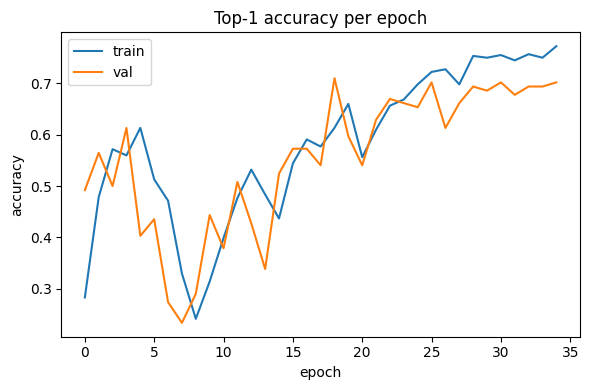

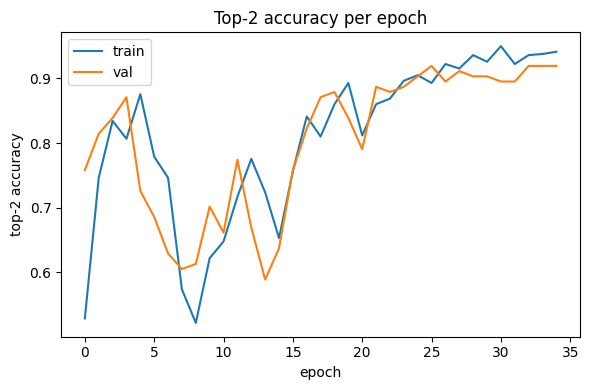

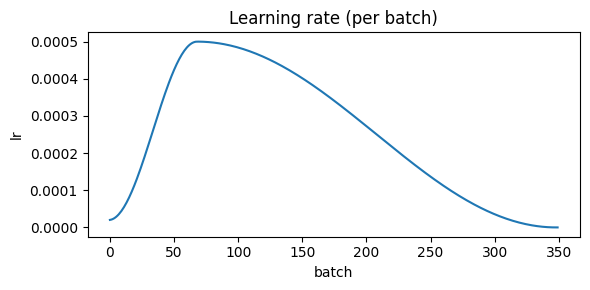

In [ ]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"],   label="val")
plt.title("Loss per epoch"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

# Accuracy (top-1)
plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# Top-2
plt.figure(figsize=(6,4))
plt.plot(history["train_top2"], label="train")
plt.plot(history["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# LR schedule across batches (OneCycle)
if history["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history["lrs"])
    plt.title("Learning rate (per batch)"); plt.xlabel("batch"); plt.ylabel("lr")
    plt.tight_layout(); plt.show()

## Evaluación

In [ ]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 0) Carga el mejor modelo
model.load_state_dict(torch.load("best_model_swin_t.pt", map_location=DEVICE))
model.to(DEVICE).eval()

criterion = torch.nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test:   # dl_test debe entregar tensores normalizados igual que train/val
        xb = xb.to(DEVICE, non_blocking=True)    # yb se queda en CPU; está bien para sklearn
        logits = model(xb)                       # (B, C)

        # acumular para métricas globales
        all_logits.append(logits.cpu())
        all_targets.append(yb)

        # loss y top-k
        loss = criterion(logits.cpu(), yb)       # logits a CPU para usar el mismo yb
        test_loss += loss.item() * xb.size(0)
        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()
        _, top2 = logits.topk(2, dim=1)          # en device
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()
        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

# Ajustar el orden/nombres según label encoder
target_names = ["ASD","Normal","PDA","VSD"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-324712328.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 0.7149375, 'acc': 0.736, 'top2': 0.888}
              precision    recall  f1-score   support

         ASD     0.6522    0.9375    0.7692        32
      Normal     0.7083    0.5862    0.6415        29
         PDA     0.7941    0.8182    0.8060        33
         VSD     0.8571    0.5806    0.6923        31

    accuracy                         0.7360       125
   macro avg     0.7529    0.7306    0.7273       125
weighted avg     0.7535    0.7360    0.7302       125

[[30  1  1  0]
 [ 8 17  3  1]
 [ 1  3 27  2]
 [ 7  3  3 18]]


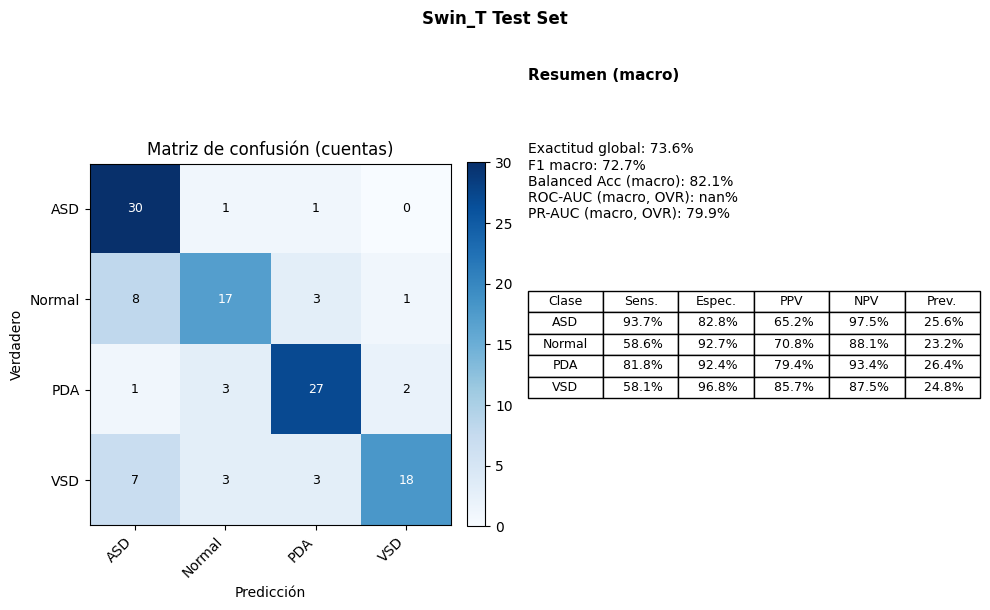

In [ ]:
metrics, fig = eval_multiclase(y_true, y_pred, y_prob, target_names, titulo="Swin_T Test Set")

# Modelo Alternativo 5 - EfficientNetV2-S

## Justificación del modelo

EfficientNetV2-S es una evolución de la familia de modelos EfficientNet, la cual esta diseñada para alcanzar un equilibrio óptimo entre eficiencia computacional y capacidad de generalización. Tiene una arquitectura que combina bloques MBConv y Fused-MBConv, lo que mejora la propagación del gradiente en redes profundas y acelera el entrenamiento sin sacrificar precisión.
<br><br>


Desempeño en imágenes biomédicas: <br>
Los modelos EfficientNet (sobre todo sus versiones V2) han demostrado un excelente rendimiento en tareas de clasificación médica (radiografías, tomografías, ecocardiogramas) por su habilidad para capturar patrones finos de textura y contraste, características comunes en estructuras cardíacas y pulmonares.
<br><br>


Tecnicas de regularizacion y estabilidad: <br>
Incluye técnicas integradas como stochastic depth, label smoothing y data augmentation-friendly normalization, que ayudan a evitar el sobreajuste, un riesgo común en datasets clínicos.

<br><br>


Referencias: <br>
- [Acemic of radiology EfficientNetV2-S](https://www.academicradiology.org/article/S1076-6332(22)00632-8/fulltext)
- [A lightweight CNN-based network on COVID-19 detection using X-ray and CT images](https://www.sciencedirect.com/science/article/pii/S0010482522003961)
- [EfficientNetV2 Convolutional Neural Networks on Classification of Multiple Chest Diseases](https://pmc.ncbi.nlm.nih.gov/articles/PMC9748720/)
- [Image-based deep learning in diagnosing mycoplasma pneumonia on pediatric chest X-rays](https://pubmed.ncbi.nlm.nih.gov/39529076/)



## Implementación

In [ ]:
# =========================
# Modelo Alternativo 5: EfficientNetV2-S
# =========================
import torch, numpy as np, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

history_effv2s = {
    "train_loss": [], "train_acc": [], "train_top2": [],
    "val_loss":   [], "val_acc":   [], "val_top2":   [],
    "lrs": []
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Datos: X_*_normalized (N,320,320,1) en [0,1]; Y_*_encoded one-hot (N,4)
num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

# (opcional, informativo)
def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

# ---- Transforms con pesos de EfficientNetV2-S ----
effv2_weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
effv2_preprocess = effv2_weights.transforms()  # incluye resize, toTensor y normalización

train_transforms_eff = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    effv2_preprocess,
])
val_test_transforms_eff = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    effv2_preprocess,
])

# Dataset minimalista (usa el tuyo si ya lo definiste)
class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, transform=None):
        self.x = (x_nhwc * 255).astype(np.uint8)
        self.y = y_idx.astype(np.int64)
        self.transform = transform
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, i):
        img = self.x[i]                         # (H,W,1)
        if self.transform is not None:
            img = self.transform(img)           # (3,H,W) float normalizado
        else:
            img = torch.from_numpy(np.transpose(img, (2,0,1))).float() / 255.0
            img = img.repeat(3, 1, 1)
        return img, torch.tensor(self.y[i])

# DataLoaders
BATCH = 64
train_dataset_eff = NumpyGrayDataset(X_train_normalized, y_train_idx, transform=train_transforms_eff)
val_dataset_eff   = NumpyGrayDataset(X_val_normalized,   y_val_idx,   transform=val_test_transforms_eff)
test_dataset_eff  = NumpyGrayDataset(X_test_normalized,  y_test_idx,  transform=val_test_transforms_eff)

dl_train_eff = DataLoader(train_dataset_eff, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=True)
dl_val_eff   = DataLoader(val_dataset_eff,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test_eff  = DataLoader(test_dataset_eff,  batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Modelo
class EfficientNetV2SClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True, p_drop=0.4):
        super().__init__()
        weights = effv2_weights if pretrained else None
        m = models.efficientnet_v2_s(weights=weights)
        # classifier = [Dropout, Linear]
        in_feats = m.classifier[1].in_features
        m.classifier[1] = nn.Sequential(
            nn.Dropout(p=p_drop),
            nn.Linear(in_feats, num_classes)
        )
        self.net = m
    def forward(self, x):
        return self.net(x)

model_eff = EfficientNetV2SClassifier(num_classes).to(device)

criterion_eff = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_eff = AdamW(model_eff.parameters(), lr=5e-4, weight_decay=1e-4)

EPOCHS = 35
steps_per_epoch = len(dl_train_eff)
scheduler_eff = OneCycleLR(optimizer_eff, max_lr=5e-4, epochs=EPOCHS,
                           steps_per_epoch=steps_per_epoch, pct_start=0.2)

scaler_eff = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch_eff(loader, train=True):
    model_eff.train(train)
    total_loss = total = a1 = a2 = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer_eff.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model_eff(xb)
                loss   = criterion_eff(logits, yb)
            scaler_eff.scale(loss).backward()
            scaler_eff.step(optimizer_eff)
            scaler_eff.update()
            scheduler_eff.step()
            history_effv2s["lrs"].append(optimizer_eff.param_groups[0]['lr'])
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model_eff(xb)
                loss   = criterion_eff(logits, yb)
        bs = xb.size(0)
        total_loss += loss.item()*bs; total += bs
        a1 += topk_acc(logits, yb, 1)*bs; a2 += topk_acc(logits, yb, 2)*bs
    return total_loss/total, a1/total, a2/total


best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch_eff(dl_train_eff, train=True)
    va_loss, va_a1, va_a2 = run_epoch_eff(dl_val_eff,   train=False)

    history_effv2s["train_loss"].append(tr_loss); history_effv2s["train_acc"].append(tr_a1); history_effv2s["train_top2"].append(tr_a2)
    history_effv2s["val_loss"].append(va_loss);   history_effv2s["val_acc"].append(va_a1);   history_effv2s["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer_eff.param_groups[0]['lr']:.2e}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model_eff.state_dict(), "efficientnet_v2s_best.pt")

torch.save(model_eff.state_dict(), "efficientnet_v2s_last.pt")

Device: cuda
Dataset norm: mean=0.6007, std=0.1668
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 146MB/s]
/tmp/ipython-input-3301885728.py:86: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_eff = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-3301885728.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipython-input-3301885728.p

Epoch 01 | train 1.4049 acc 0.263 top2 0.499 | val 1.3827 acc 0.250 top2 0.565 | lr 4.44e-05
Epoch 02 | train 1.3375 acc 0.397 top2 0.625 | val 1.3391 acc 0.403 top2 0.685 | lr 1.13e-04
Epoch 03 | train 1.2377 acc 0.541 top2 0.756 | val 1.1708 acc 0.613 top2 0.855 | lr 2.11e-04
Epoch 04 | train 1.0027 acc 0.667 top2 0.877 | val 1.3061 acc 0.452 top2 0.605 | lr 3.19e-04
Epoch 05 | train 0.8192 acc 0.744 top2 0.941 | val 1.3292 acc 0.427 top2 0.718 | lr 4.16e-04
Epoch 06 | train 0.7192 acc 0.805 top2 0.955 | val 1.1550 acc 0.661 top2 0.782 | lr 4.80e-04
Epoch 07 | train 0.6754 acc 0.831 top2 0.971 | val 1.2786 acc 0.419 top2 0.798 | lr 5.00e-04
Epoch 08 | train 0.6022 acc 0.888 top2 0.972 | val 1.2317 acc 0.565 top2 0.823 | lr 4.98e-04
Epoch 09 | train 0.6688 acc 0.836 top2 0.974 | val 0.6744 acc 0.847 top2 0.968 | lr 4.93e-04
Epoch 10 | train 0.6621 acc 0.841 top2 0.978 | val 1.3454 acc 0.589 top2 0.774 | lr 4.85e-04
Epoch 11 | train 0.6184 acc 0.874 top2 0.983 | val 1.0900 acc 0.629 to

## Desempeño en entrenamiento

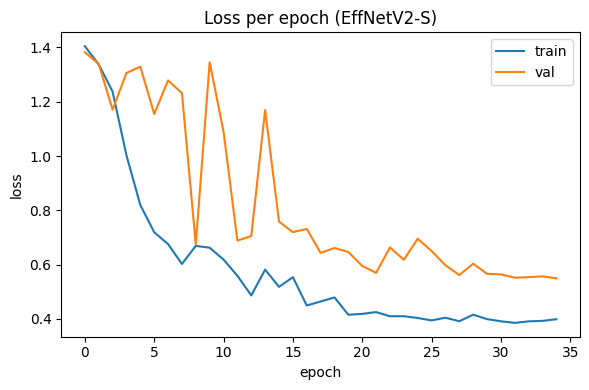

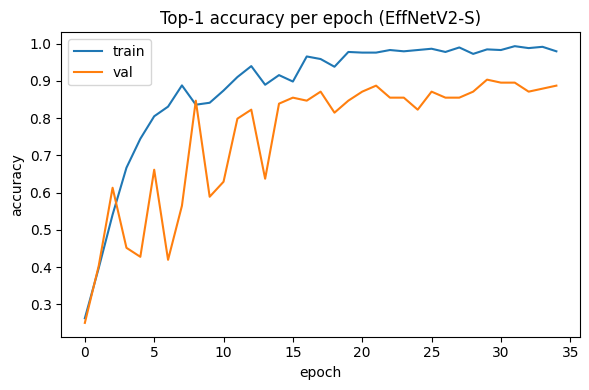

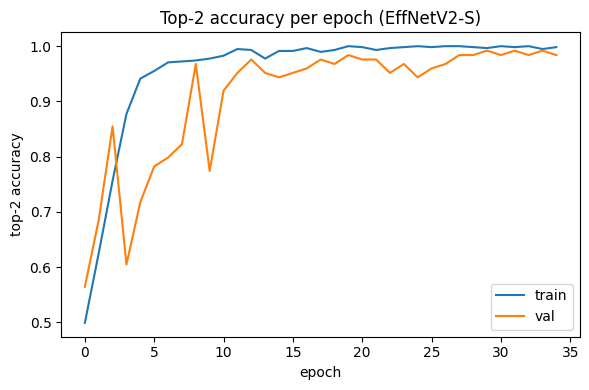

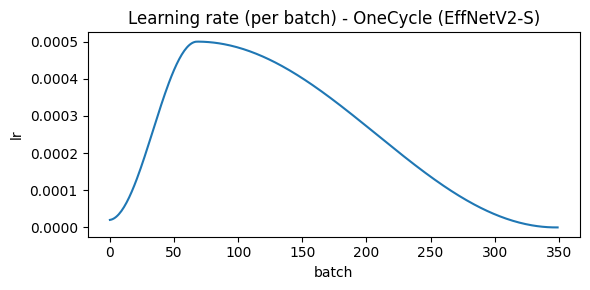

In [ ]:
# Gráficas
plt.figure(figsize=(6,4))
plt.plot(history_effv2s["train_loss"], label="train")
plt.plot(history_effv2s["val_loss"],   label="val")
plt.title("Loss per epoch (EffNetV2-S)"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history_effv2s["train_acc"], label="train")
plt.plot(history_effv2s["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch (EffNetV2-S)"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history_effv2s["train_top2"], label="train")
plt.plot(history_effv2s["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch (EffNetV2-S)"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

if history_effv2s["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history_effv2s["lrs"])
    plt.title("Learning rate (per batch) - OneCycle (EffNetV2-S)")
    plt.xlabel("batch"); plt.ylabel("lr"); plt.tight_layout(); plt.show()

**Curva de perdida**

- El loss de entrenamiento desciende de forma constante desde 1.4 hasta 0.35 lo que indica un aprendizaje estable.
- El loss de val vonverge a valores de 0.55 a 0.60 lo que puede indicar buena estabilidad.
- La separacion entre las curvas sugiere un ligero sobreajuste, probablemente debido al buen rendimiento dle modelo que se podria trabajar con tecnicas de overfitting.

**Top 1 accurancy**
- El modelo alcanza una precision de entranmiento cercana al 99% en la epoca 35 lo que puediera sugerir un overfitting pero, en validacion un porcentaje del 85-90% lo cual es excelente y puede ser un buen indicativo de una buena generalizacion de los datos por parte del modelo.
- El rapido ascenso a 80% en las primeras 10 epoch puede ser debido a que el modelo aprendio caracteristicas discriminativas de manera temprana, posiblemente bordes, estructuras vasculares o contrastes toracicos lo cual apoyaria a una generalizacion del modelo pero tambien a un ligero overfitting.
- Buena brecha entra train y val del 10%, redelja un compartamiento tipico en redes neuronales con datasets limitas.

**Top 2 accurancy**
- La curva muestra una rápida estabilización por encima del 95 % tanto en entrenamiento como en validación a partir de la época ~12. Esto significa que en el 95–98 % de los casos, la clase verdadera se encuentra entre las dos predicciones más probables del modelo.
- La convergencia casi paralela de las curvas de train y val indica buena generalización: el modelo mantiene su capacidad discriminativa incluso fuera del conjunto de entrenamiento.

## Evaluación

In [ ]:
# =========================
# Evaluación (EfficientNetV2-S)
# =========================
model_eff.load_state_dict(torch.load("efficientnet_v2s_best.pt", map_location=device))
model_eff.to(device).eval()

criterion_eval = nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test_eff:
        xb = xb.to(device, non_blocking=True)
        logits = model_eff(xb)

        all_logits.append(logits.cpu())
        all_targets.append(yb)

        loss = criterion_eval(logits.cpu(), yb)
        test_loss += loss.item() * xb.size(0)

        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()

        _, top2 = logits.topk(2, dim=1)
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()

        total += xb.size(0)

logits = torch.cat(all_logits)
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

target_names = ["ASD","Normal","PDA","VSD"]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-82246793.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 0.54162109375, 'acc': 0.808, 'top2': 0.92}
              precision    recall  f1-score   support

         ASD     0.7778    0.8750    0.8235        32
      Normal     0.7692    0.6897    0.7273        29
         PDA     0.7949    0.9394    0.8611        33
         VSD     0.9167    0.7097    0.8000        31

    accuracy                         0.8080       125
   macro avg     0.8146    0.8034    0.8030       125
weighted avg     0.8148    0.8080    0.8053       125

[[28  4  0  0]
 [ 6 20  2  1]
 [ 1  0 31  1]
 [ 1  2  6 22]]


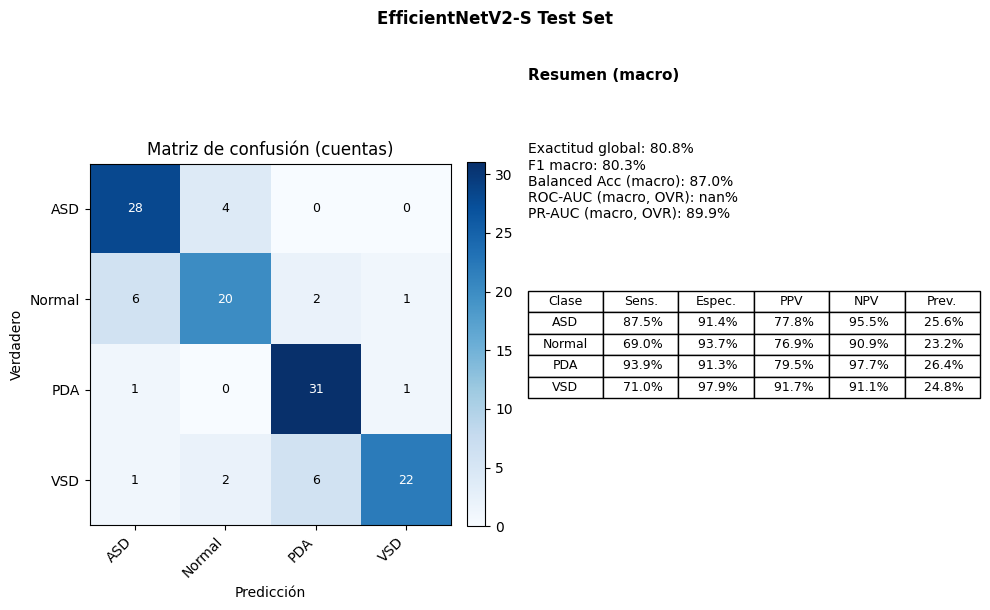

In [ ]:
metrics, fig = eval_multiclase(y_true, y_pred, y_prob, target_names, titulo="EfficientNetV2-S Test Set")


**Analisis general:**
El modelo logro un equilibrio entre precision y sensibilidad, superando el umbral del 80% en las metricas clave.

La metrica de  "Balanced Accurancy" es alta (87%) lo que indica que las clases estan razonablemente bien balanceadas y representadas y que el modelo no favorece exclusivamente a una clase en particular.

**Analisis de Matriz de confusion:**
- PDA y ASD son las clases con mejor rendimiento global (sensibilidad >85%).
- Normal y VSD presentan mayor confusión mutua.
- Las principales confusiones son: Normal/ASD y VSD/PDA, lo cual indica que probablemente existen estructuras fisiológicamente similares, ambos pares comparten características radiográficas similares (flujo vascular o tamaño cardíaco).

**Conclusion modelo**

- Ligera evidencia de overfitting no severa.
  - La curva de loss de entrenamiento sigue bajando hasta ~0.35, mientras que la de validación se estabiliza cerca de ~0.55-0.60, aqui hay cierta brecha, pero sin divergencia.
  - Las curvas de accuracy (top-1 y top-2) de validación acompañan de forma paralela al entrenamiento, lo que indica buena generalización.
  - El rendimiento en test (80.8 % accuracy, 87 % balanced accuracy) confirma que el modelo mantiene desempeño alto fuera del conjunto de entrenamiento.


En términos generales: el modelo aprendió bien sin memorizar el dataset; el pequeño margen entre train y val es esperable por la alta capacidad de EfficientNetV2-S y el tamaño moderado de tus datos.

Se muestra una generalización sólida y un leve sobreajuste controlado, alcanzando más del 80 % de exactitud global y una balanced accuracy del 87 %.
Aprende patrones clínicamente coherentes, distingue bien las clases con mayor contraste radiográfico (PDA, ASD) y mantiene una Top-2 accuracy superior al 95 %, lo que lo convierte en un modelo confiable, eficiente y útil para apoyo diagnóstico, más que en riesgo de sobreentrenamiento.

# Modelo Alternativo 6 - ConvNeXt-Tiny

## Justificación del modelo

ConvNeXt-Tiny es una reinterpretación moderna de las CNN tradicionales, inspirada en la estructura de los Transformers. Este tipo de modelo se construyó ajustando arquitecturas ResNet con principios de diseño de ViT (bloques isotrópicos, kernel 7×7, normalización por capas, mayor profundidad y ancho de canal), logrando un rendimiento comparable a los modelos vision transformers, pero conservando la eficiencia y estabilidad de entrenamiento de las CNN.


Puntos clave:
- Las radiografías torácicas requieren identificar estructuras anatómicas (corazón, pulmones, vasos, flujo pulmonar, etc) donde la posición y las proporciones espaciales son críticas para la clasificacion. ConvNeXt puede permitir una localización más estable de regiones relevantes.

- Arquitectura moderna y eficiente: Combina lo mejor de ambos mundos.
  - La jerarquía convolucional (robusta ante rotaciones, traslaciones y ruido
  - La normalización y escalabilidad de los Transformers, ofreciendo una arquitectura state-of-the-art con buenos resultados en generalización.

- Su estructura convolucional jerárquica lo hace compatible lo hace compatible con métodos de interpretabilidad como Grad-CAM o Score-CAM, facilitando la localización de regiones de atención cardíaca o pulmonar y nos permitiria analisis en la fase de la validación clínica del modelo.


En general, como ya mencionamos, ConvNeXt-Tiny combina la robustez y la interpretabilidad de las CNN con las mejoras de diseño inspiradas en Transformers, ofreciendo una alternativa moderna, eficiente y explicable para la detección de patrones cardíacos en radiografías médicas.

## Implementación

In [ ]:
# =========================
# Modelo Alternativo 6: ConvNeXt-Tiny
# =========================
import torch, numpy as np, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Historial para gráficas (mismo formato que tu ejemplo)
history_cnx_tiny = {
    "train_loss": [], "train_acc": [], "train_top2": [],
    "val_loss":   [], "val_acc":   [], "val_top2":   [],
    "lrs": []
}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Datos: X_*_normalized (N,320,320,1) en [0,1]; Y_*_encoded one-hot (N,4)
num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

# (Opcional, informativo)
def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

# ---- Transforms basados en los pesos de ConvNeXt-Tiny (ImageNet) ----
cnx_weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
cnx_preprocess = cnx_weights.transforms()

train_transforms_cnx = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    cnx_preprocess,  # tensor + normalización ImageNet
])
val_test_transforms_cnx = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    cnx_preprocess
])

# Dataset minimalista (usa el tuyo si ya lo definiste y prefieres)
class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, transform=None):
        self.x = (x_nhwc * 255).astype(np.uint8)  # a 0..255
        self.y = y_idx.astype(np.int64)
        self.transform = transform
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, i):
        img = self.x[i]                        # (H,W,1)
        if self.transform is not None:
            img = self.transform(img)          # -> (3,H,W) float normalizado
        else:
            img = torch.from_numpy(np.transpose(img, (2,0,1))).float() / 255.0
            img = img.repeat(3, 1, 1)
        return img, torch.tensor(self.y[i])

# DataLoaders
BATCH = 64
train_dataset_cnx = NumpyGrayDataset(X_train_normalized, y_train_idx, transform=train_transforms_cnx)
val_dataset_cnx   = NumpyGrayDataset(X_val_normalized,   y_val_idx,   transform=val_test_transforms_cnx)
test_dataset_cnx  = NumpyGrayDataset(X_test_normalized,  y_test_idx,  transform=val_test_transforms_cnx)

dl_train_cnx = DataLoader(train_dataset_cnx, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=True)
dl_val_cnx   = DataLoader(val_dataset_cnx,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test_cnx  = DataLoader(test_dataset_cnx,  batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Modelo
class ConvNeXtTinyClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True, p_drop=0.4):
        super().__init__()
        weights = cnx_weights if pretrained else None
        m = models.convnext_tiny(weights=weights)
        # La cabeza por defecto: classifier = [LayerNorm2d, Flatten, Linear(768->1000)]
        in_feats = m.classifier[2].in_features
        m.classifier[2] = nn.Sequential(
            nn.Dropout(p=p_drop),
            nn.Linear(in_feats, num_classes)
        )
        self.net = m
    def forward(self, x):
        return self.net(x)

model_cnx = ConvNeXtTinyClassifier(num_classes).to(device)

# ---- Pérdida + optimizer + OneCycle ----
criterion_cnx = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_cnx = AdamW(model_cnx.parameters(), lr=5e-4, weight_decay=1e-4)

EPOCHS = 35
steps_per_epoch = len(dl_train_cnx)
scheduler_cnx = OneCycleLR(optimizer_cnx, max_lr=5e-4, epochs=EPOCHS,
                           steps_per_epoch=steps_per_epoch, pct_start=0.2)

scaler_cnx = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch_cnx(loader, train=True):
    model_cnx.train(train)
    total_loss = total = a1 = a2 = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer_cnx.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model_cnx(xb)
                loss   = criterion_cnx(logits, yb)
            scaler_cnx.scale(loss).backward()
            scaler_cnx.step(optimizer_cnx)
            scaler_cnx.update()
            scheduler_cnx.step()
            history_cnx_tiny["lrs"].append(optimizer_cnx.param_groups[0]['lr'])
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model_cnx(xb)
                loss   = criterion_cnx(logits, yb)
        bs = xb.size(0)
        total_loss += loss.item()*bs; total += bs
        a1 += topk_acc(logits, yb, 1)*bs; a2 += topk_acc(logits, yb, 2)*bs
    return total_loss/total, a1/total, a2/total


best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch_cnx(dl_train_cnx, train=True)
    va_loss, va_a1, va_a2 = run_epoch_cnx(dl_val_cnx,   train=False)

    history_cnx_tiny["train_loss"].append(tr_loss); history_cnx_tiny["train_acc"].append(tr_a1); history_cnx_tiny["train_top2"].append(tr_a2)
    history_cnx_tiny["val_loss"].append(va_loss);   history_cnx_tiny["val_acc"].append(va_a1);   history_cnx_tiny["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer_cnx.param_groups[0]['lr']:.2e}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model_cnx.state_dict(), "convnext_tiny_best.pt")

torch.save(model_cnx.state_dict(), "convnext_tiny_last.pt")


Device: cuda
Dataset norm: mean=0.6007, std=0.1668
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 206MB/s]
/tmp/ipython-input-1901392416.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_cnx = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1901392416.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1901392416.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


Epoch 01 | train 1.3962 acc 0.297 top2 0.575 | val 1.3124 acc 0.452 top2 0.726 | lr 4.44e-05
Epoch 02 | train 1.2518 acc 0.477 top2 0.713 | val 1.1213 acc 0.597 top2 0.839 | lr 1.13e-04
Epoch 03 | train 1.1690 acc 0.506 top2 0.786 | val 1.1895 acc 0.500 top2 0.750 | lr 2.11e-04
Epoch 04 | train 1.1594 acc 0.534 top2 0.789 | val 1.4783 acc 0.468 top2 0.790 | lr 3.19e-04
Epoch 05 | train 1.1862 acc 0.518 top2 0.798 | val 1.2393 acc 0.460 top2 0.790 | lr 4.16e-04
Epoch 06 | train 1.0465 acc 0.582 top2 0.858 | val 1.0578 acc 0.629 top2 0.855 | lr 4.80e-04
Epoch 07 | train 1.0986 acc 0.573 top2 0.851 | val 1.0701 acc 0.589 top2 0.798 | lr 5.00e-04
Epoch 08 | train 1.0501 acc 0.587 top2 0.850 | val 1.2004 acc 0.556 top2 0.774 | lr 4.98e-04
Epoch 09 | train 1.0229 acc 0.629 top2 0.834 | val 1.5018 acc 0.427 top2 0.726 | lr 4.93e-04
Epoch 10 | train 1.0752 acc 0.585 top2 0.827 | val 1.0780 acc 0.621 top2 0.871 | lr 4.85e-04
Epoch 11 | train 0.9168 acc 0.677 top2 0.891 | val 0.9614 acc 0.661 to

## Desempeño en entrenamiento

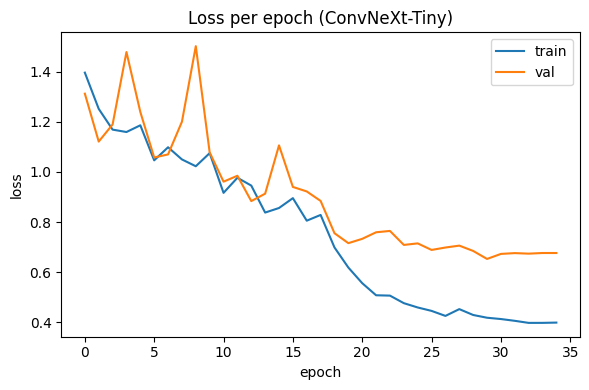

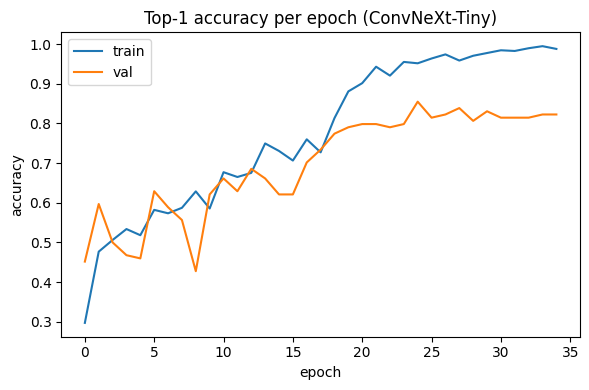

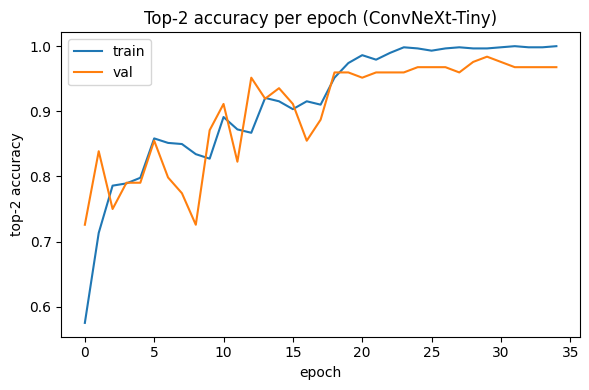

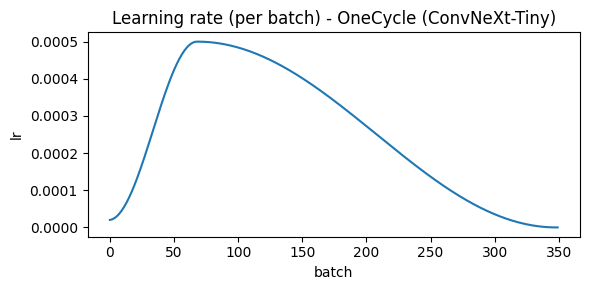

In [ ]:
# ---- Gráficas entrenamiento ----
plt.figure(figsize=(6,4))
plt.plot(history_cnx_tiny["train_loss"], label="train")
plt.plot(history_cnx_tiny["val_loss"],   label="val")
plt.title("Loss per epoch (ConvNeXt-Tiny)"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history_cnx_tiny["train_acc"], label="train")
plt.plot(history_cnx_tiny["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch (ConvNeXt-Tiny)"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history_cnx_tiny["train_top2"], label="train")
plt.plot(history_cnx_tiny["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch (ConvNeXt-Tiny)"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

if history_cnx_tiny["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history_cnx_tiny["lrs"])
    plt.title("Learning rate (per batch) - OneCycle (ConvNeXt-Tiny)")
    plt.xlabel("batch"); plt.ylabel("lr"); plt.tight_layout(); plt.show()


**Curva de perdida**

- El loss de entrenamiento desciende de forma continua hasta ~0.35, mientras que el loss de validación se estabiliza en torno a 0.65–0.70 a partir de la época 20.
- La diferencia entre ambas curvas sugiere ligero sobreajuste: el modelo sigue mejorando en entrenamiento pero deja de hacerlo en validación después de la mitad del ciclo.


**Top 1 accurancy**
- El entrenamiento alcanza casi 99 % hacia la época 35, mientras que la validación se estabiliza en torno al 80–83 %.
- Esta brecha refleja cierto sobreajuste moderado, común en redes grandes (ConvNeXt tiene alta capacidad). Pero, la validación no se degrada, lo que indica que el modelo aún generaliza correctamente y podría beneficiarse de regularización adicional o data augmentation.


**Top 2 accurancy**
- La métrica alcanza rápidamente más del 95 % tanto en entrenamiento como en validación a partir de la época 15.
- Esto confirma que, aunque el modelo pueda errar su primera predicción, la clase correcta está casi siempre entre las dos primeras opciones, muy útil en contextos clínicos.

## Evaluación

In [ ]:
# =========================
# Evaluación en TEST (ConvNeXt-Tiny)
# =========================
model_cnx.load_state_dict(torch.load("convnext_tiny_best.pt", map_location=device))
model_cnx.to(device).eval()

criterion_eval = nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test_cnx:
        xb = xb.to(device, non_blocking=True)
        logits = model_cnx(xb)

        all_logits.append(logits.cpu())
        all_targets.append(yb)

        loss = criterion_eval(logits.cpu(), yb)
        test_loss += loss.item() * xb.size(0)

        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()

        _, top2 = logits.topk(2, dim=1)
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()

        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

target_names = ["ASD","Normal","PDA","VSD"]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-2547445304.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 0.536916015625, 'acc': 0.776, 'top2': 0.904}
              precision    recall  f1-score   support

         ASD     0.6744    0.9062    0.7733        32
      Normal     0.7200    0.6207    0.6667        29
         PDA     0.8333    0.9091    0.8696        33
         VSD     0.9524    0.6452    0.7692        31

    accuracy                         0.7760       125
   macro avg     0.7950    0.7703    0.7697       125
weighted avg     0.7959    0.7760    0.7730       125

[[29  2  1  0]
 [ 8 18  3  0]
 [ 0  2 30  1]
 [ 6  3  2 20]]


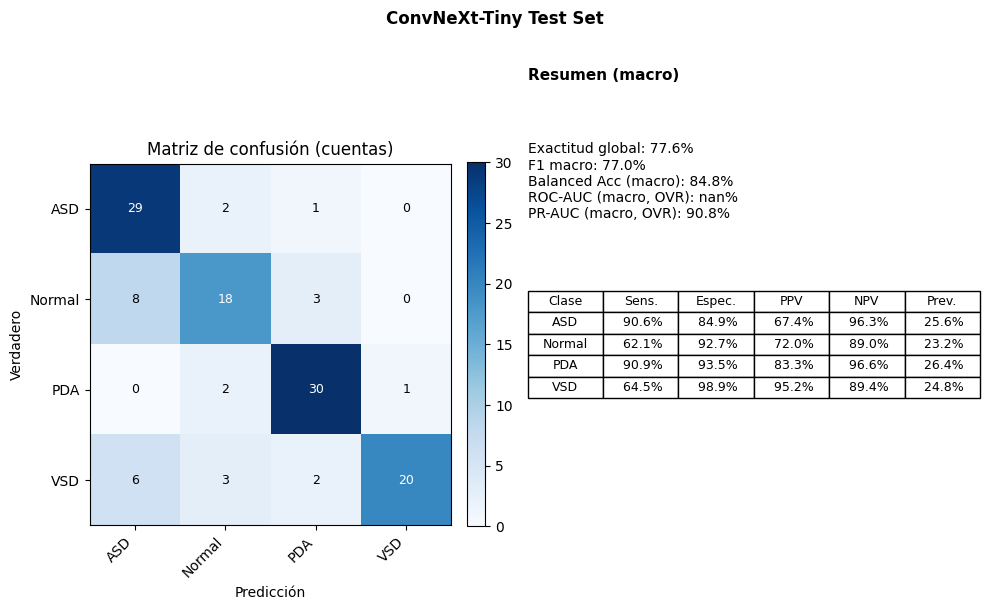

In [ ]:
metrics, fig = eval_multiclase(y_true, y_pred, y_prob, target_names, titulo="ConvNeXt-Tiny Test Set")


**Analisis general:**
Rendimiento aceptable aunque ligeramente inferior a EfficientNetV2-S (80.8 %).
El modelo mantiene una buena capacidad discriminativa global y conserva equilibrio entre clases (Balanced Acc > 84 %), menor que EfficentnetV2.


**Analisis de Matriz de confusion:**
- Normal/ASD y VSD/PDA, al igual que el modelo anterior, lo que peude ser coherente al tener clases con similitudes clínicas (patrones vasculares y morfología cardíaca).
- El modelo no muestra sesgo fuerte hacia una sola clase, lo que es positivo.

**Conclusion modelo**


El modelo ConvNeXt-Tiny presenta ligero sobreajuste controlado, con 77.6 % de exactitud global y 84.8 % de balanced accuracy.

Su desempeño no es el mejor y existe la posibilidad de una mejora, sin embargo para entornos de datasets ligeros es muy competitivo y clínicamente relevante, destacando por su alta sensibilidad en ASD y PDA, aunque con menor rendimiento en VSD y Normal.

En comparación con EfficientNetV2-S, ConvNeXt-Tiny mantiene mayor estabilidad top-2 pero **menor generalización global,** lo que lo posiciona como un modelo eficiente y confiable, aunque algo más dependiente de la regularización y del equilibrio de clases.

# Analisis comparativo de los modelos alternativos

**Tabla comparativa de Desempeño global**

| Modelo                          | Exactitud Global | F1 Macro | Balanced Acc (Macro) | PR-AUC | Observaciones Clave                                                         |
| :------------------------------ | :--------------: | :------: | :------------------: | :----: | :-------------------------------------------------------------------------- |
| **ViT (Modelo 1)**              |     **52.0%**    |   50.6%  |         67.7%        |  59.8% | Subajuste severo (underfitting). Modelo no converge bien.                   |
| **DenseNet (Modelo 2)**         |     **82.4%**    |   82.0%  |         88.1%        |  89.3% | Excelente generalización, entrenamiento estable.                            |
| **ResNet50 (Modelo 3)**         |     **82.4%**    |   82.2%  |         88.0%        |  89.0% | Similar a DenseNet, ligeramente mejor PPV y NPV.                            |
| **Swin-T (Modelo 4)**           |     **73.6%**    |   72.7%  |         82.1%        |  79.9% | Buen desempeño, pero menor estabilidad; posibles problemas de convergencia. |
| **EfficientNetV2-S (Modelo 5)** |     **80.8%**    |   80.3%  |         87.0%        |  89.9% | Alto desempeño con excelente balance entre sensibilidad y especificidad.    |
| **ConvNeXt-Tiny (Modelo 6)**    |     **77.6%**    |   77.0%  |         84.8%        |  90.8% | Buen desempeño, pero más overfitting que EfficientNet.                      |


**Entrenamiento y Estabilidad**
- ViT: fluctuaciones altas en loss y accuracy; el modelo no converge adecuadamente → dataset pequeño vs arquitectura muy grande.
- DenseNet y ResNet50: curvas suaves, entrenamiento estable y convergencia clara → excelente relación bias/variance.
- Swin-T: pérdida más ruidosa y validación con fluctuaciones → indica posible sensibilidad al tamaño de batch o LR.
- EfficientNetV2-S: curvas limpias, sin signs evidentes de overfitting; entrenamiento estable.
- ConvNeXt-Tiny: validación se estabiliza con menor gap, pero accuracy menor que EfficientNet.
- Mejor estabilidad: DenseNet ≈ ResNet50 ≈ EfficientNetV2-S
- Mas inestables: Vit y Swin-T


**Capacidad de Generalización (Train vs Val)**
- ViT: Subentrenado.
- Swin-T y ConvNeXt: ligera separación train-val, overfitting moderado.
- EfficientNetV2-S, DenseNet, ResNet50: excelente balance train-val.
- Mejor generalizacion: EfficientNetV2-S
- Peor generalizacion: ViT


**Matriz de confusion y sensibilidad clinica**
- Clases más difíciles: Normal y VSD, en todos los modelos.
- ASD y PDA se predicen consistentemente con alta sensibilidad (≈90%).
- EfficientNetV2-S y DenseNet mantienen mejor equilibrio entre sensibilidad (≥85%) y especificidad (≥91%).
- ResNet50 logra el PPV más alto (predicciones más precisas).
- ConvNeXt-Tiny mejora PR-AUC, pero pierde algo de exactitud.
- Mejor balance: EfficientNetV2-S
- Mas preciso (menores falsos positivos): ResNet50


**Metricas globales**

| Métrica                                            | Mejor Modelo                |
| :------------------------------------------------- | :-------------------------- |
| **Exactitud global**                               | DenseNet / ResNet50 (82.4%) |
| **F1-macro (balance clases)**                      | ResNet50 (82.2%)            |
| **Balanced Accuracy**                              | DenseNet (88.1%)            |
| **PR-AUC**                                         | ConvNeXt-Tiny (90.8%)       |
| **Sensibilidad Promedio (clínicamente relevante)** | EfficientNetV2-S (85.6%)    |


**Identificación de los Mejores 2 Modelos**

1. EfficientNetV2-S: Mejor equilibrio entre generalización, sensibilidad y estabilidad. Alto desempeño clínico (Balanced Acc 87%, PR-AUC 89.9%). Menor overfitting y gran robustez en validación. Ideal para despliegue inicial en entorno médico.

2. ResNet50: Desempeño sólido y estable, métricas altas (F1 y accuracy = 82%). Fácil de entrenar, reproducible, y con interpretabilidad madura (Grad-CAMs disponibles). Excelente baseline de referencia.

**Conclusiones generales**
- EfficientNetV2-S demuestra ser el modelo óptimo por su eficiencia y estabilidad, balanceando sensibilidad (detección de casos positivos) y especificidad (reducción de falsos positivos).
- ResNet50 se mantiene como el modelo base robusto, con resultados consistentes y alta precisión.
- DenseNet queda muy cercano al segundo lugar; podría preferirse si se optimizan hiperparámetros o se aplica fine-tuning adicional.
- ViT y Swin-T muestran inestabilidad y necesidad de datasets más grandes o regularización adicional (Dropout, AugMix, Mixup).


# Mejores Modelos - Analisis Final

**Comparativa General de Todos los Modelos**

| Modelo                             | Exactitud Global |  F1 Macro | Balanced Acc (Macro) |   PR-AUC  | Observaciones                                              |
| :--------------------------------- | :--------------: | :-------: | :------------------: | :-------: | :--------------------------------------------------------- |
| **ViT**                            |       52.0%      |   50.6%   |         67.7%        |   59.8%   | Subentrenamiento; no converge bien, resultados inestables. |
| **DenseNet**                       |       82.4%      |   82.0%   |         88.1%        |   89.3%   | Excelente estabilidad y generalización, alto recall.       |
| **ResNet50**                       |       82.4%      |   82.2%   |         88.0%        |   89.0%   | Muy sólido, ligeramente más preciso (mejor PPV).           |
| **Swin-T**                         |       73.6%      |   72.7%   |         82.1%        |   79.9%   | Buen resultado, pero con oscilaciones en validación.       |
| **EfficientNetV2-S**               |       80.8%      |   80.3%   |         87.0%        |   89.9%   | Muy buen balance clínico y estabilidad.                    |
| **ConvNeXt-Tiny**                  |       77.6%      |   77.0%   |         84.8%        |   90.8%   | Buen rendimiento general, aunque más overfitting.          |
| **EfficientNetB2 (Semana Pasada)** |     **84.8%**    | **84.3%** |       **89.6%**      | **93.0%** | Modelo con mejor desempeño global y estabilidad superior.  |


**Desempeño Global**
- El EfficientNetB2 es el modelo más equilibrado y consistente, con métricas superiores en accuracy, F1 y PR-AUC.
- EfficientNetV2-S logra un comportamiento muy similar al B2, pero sin superar su desempeño.
- DenseNet y ResNet50 se mantienen como los más estables de los nuevos modelos.
- ConvNeXt-Tiny obtiene un PR-AUC alto, pero menor exactitud global.
- Mejor desempeño total: EfficientNetB2 seguido de EfficientNetV2-S.
- Tercer lugar: DenseNet - ResNet50

**Comportamiento en entrenamiento**
- EfficientNetB2 muestra curvas limpias, sin signos de sobreajuste, con convergencia rápida y estable.
- EfficientNetV2-S es su sucesor más eficiente, pero con un leve gap entre entrenamiento y validación.
- DenseNet y ResNet50 tienen un entrenamiento sólido con buena generalización.
- ViT y Swin-T continúan mostrando oscilaciones e inestabilidad.


**Matriz de Confusión**
- En los modelos top (EfficientNetB2, DenseNet, ResNet50), las clases ASD y PDA presentan sensibilidades superiores al 90%.
- Las clases Normal y VSD siguen siendo las más difíciles, aunque B2 y DenseNet las equilibran mejor.
- EfficientNetB2 logra el mayor PR-AUC (93%), lo que indica mejor discriminación entre clases, clave en diagnóstico médico.
- Mejor balance: EfficientNetB2
- Mejor robustez multi-clase: DenseNet



**Ranking Final**

| Puesto                   | Modelo                                                                                     | Fortalezas Principales                                      |  |
| :----------------------- | :----------------------------------------------------------------------------------------- | :---------------------------------------------------------- | :--------------- |
| 1. **EfficientNetB2**    | Mayor exactitud, estabilidad y PR-AUC. Excelente sensibilidad y especificidad balanceadas. | Despliegue clínico confiable y explicativo.                 |                  |
| 2. **DenseNet**          | Muy estable, alta sensibilidad, desempeño robusto con pocos recursos.                      | Validación cruzada o producción inicial.                    |                  |
| 3. **ResNet50**          | Interpretabilidad, entrenamiento predecible y confiable.                                   | Benchmark y baseline médico estándar.                       |                  |
| 4. **EfficientNetV2-S** | Eficiencia computacional y rapidez de convergencia.                                        | Alternativa ligera o para dispositivos con menor capacidad. |                  |


**Conslusion general**

El EfficientNetB2 sigue siendo el modelo más sólido y por lo tanto el más confiable en un contexto clínico, superando a los modelos alternativos de la semana 5 en precisión global, F1 y discriminación (PR-AUC).
Los nuevos modelos DenseNet y ResNet50 logran un desempeño muy competitivo, lo que confirma que la estrategia de extracción de características y normalización implementada está funcionando correctamente.

# Mejores Modelos - Regularización

## EfficientNet

Ajustes:



*   El Dropout se sube de 0.4 a 0.5.
*   El máximo LR se pasa de 5e-4 a 1.5e-3.
* Weight decay de 1e-4 a 5e-5





### Entrenamiento

In [17]:
history_crop = {
    "train_loss": [], "train_acc": [], "train_top2": [],
    "val_loss":   [], "val_acc":   [], "val_top2":   [],
    "lrs": []  # per-batch LR track (for OneCycle)
}

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Datos: X_*_normalized (N,320,320,1) en [0,1]; Y_*_encoded one-hot (N,4)
num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

# Normalización por dataset (rápida): media y std del canal gris
def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Necesario para que las transformaciones de PIL funcionen
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)), # Rotación de +/- 10 grados, traslación del 5%
    transforms.ToTensor(), # Convierte de nuevo a tensor
])

# Transformaciones para validación/prueba (solo convertir a tensor)
# No queremos aumentar estos datos para tener una evaluación consistente
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Modificar la clase Dataset para aceptar las transformaciones
class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, mean, std, transform=None): # Añadimos 'transform'
        self.x = x_nhwc.astype(np.uint8) # Deberían ser enteros de 0-255 ANTES de normalizar
        self.y = y_idx.astype(np.int64)
        self.mean = mean
        self.std = std
        self.transform = transform # Guardar el objeto de transformación

    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, i):
        image = self.x[i] # Imagen como (H, W, C)
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(np.transpose(image, (2,0,1)).astype(np.float32))
        normalizer = transforms.Normalize(mean=[self.mean], std=[self.std])
        image = normalizer(image)
        return image, torch.tensor(self.y[i])

X_train_uint8 = (X_train_normalized * 255).astype(np.uint8)
X_val_uint8 = (X_val_normalized * 255).astype(np.uint8)
X_test_uint8 = (X_test_normalized * 255).astype(np.uint8)

BATCH = 64
train_dataset = NumpyGrayDataset(X_train_uint8, y_train_idx, mean_tr, std_tr, transform=train_transforms)
val_dataset = NumpyGrayDataset(X_val_uint8, y_val_idx, mean_tr, std_tr, transform=val_test_transforms)
test_dataset = NumpyGrayDataset(X_test_uint8, y_test_idx, mean_tr, std_tr, transform=val_test_transforms)

dl_train = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
dl_val = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

model = EfficientNetGray(num_classes).to(device)

# ---- Pérdida con label smoothing + optimizer + OneCycle ----
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=5e-5)
EPOCHS = 35
steps_per_epoch = len(dl_train)
scheduler = OneCycleLR(optimizer, max_lr=1.5e-3, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)

scaler = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = total = a1 = a2 = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
        bs = xb.size(0)
        total_loss += loss.item()*bs; total += bs
        a1 += topk_acc(logits, yb, 1)*bs; a2 += topk_acc(logits, yb, 2)*bs
    return total_loss/total, a1/total, a2/total

best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch(dl_train, train=True)
    va_loss, va_a1, va_a2 = run_epoch(dl_val,   train=False)

    history_crop["train_loss"].append(tr_loss); history_crop["train_acc"].append(tr_a1); history_crop["train_top2"].append(tr_a2)
    history_crop["val_loss"].append(va_loss);   history_crop["val_acc"].append(va_a1);   history_crop["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer.param_groups[0]['lr']:.2e}")

    # Always save the best checkpoint
    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model.state_dict(), "best.pt")

# Save the last epoch
torch.save(model.state_dict(), "last.pt")



Device: cuda
Dataset norm: mean=0.6007, std=0.1668


/tmp/ipython-input-3699246817.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-3699246817.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-3699246817.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


Epoch 01 | train 1.3801 acc 0.311 top2 0.551 | val 1.3594 acc 0.323 top2 0.540 | lr 1.33e-04
Epoch 02 | train 1.1982 acc 0.579 top2 0.826 | val 1.1664 acc 0.540 top2 0.847 | lr 3.38e-04
Epoch 03 | train 0.9240 acc 0.708 top2 0.926 | val 0.8906 acc 0.726 top2 0.952 | lr 6.34e-04
Epoch 04 | train 0.7373 acc 0.805 top2 0.955 | val 0.8041 acc 0.726 top2 0.960 | lr 9.58e-04
Epoch 05 | train 0.7020 acc 0.824 top2 0.972 | val 0.9120 acc 0.685 top2 0.903 | lr 1.25e-03
Epoch 06 | train 0.6626 acc 0.857 top2 0.965 | val 0.9857 acc 0.661 top2 0.895 | lr 1.44e-03
Epoch 07 | train 0.7137 acc 0.807 top2 0.971 | val 0.8874 acc 0.815 top2 0.968 | lr 1.50e-03
Epoch 08 | train 0.6551 acc 0.858 top2 0.976 | val 0.9811 acc 0.669 top2 0.927 | lr 1.49e-03
Epoch 09 | train 0.7925 acc 0.769 top2 0.917 | val 1.7072 acc 0.532 top2 0.718 | lr 1.48e-03
Epoch 10 | train 0.6930 acc 0.843 top2 0.952 | val 2.0072 acc 0.556 top2 0.855 | lr 1.46e-03
Epoch 11 | train 0.7263 acc 0.820 top2 0.971 | val 1.0967 acc 0.629 to

### Desempeño en entrenamiento

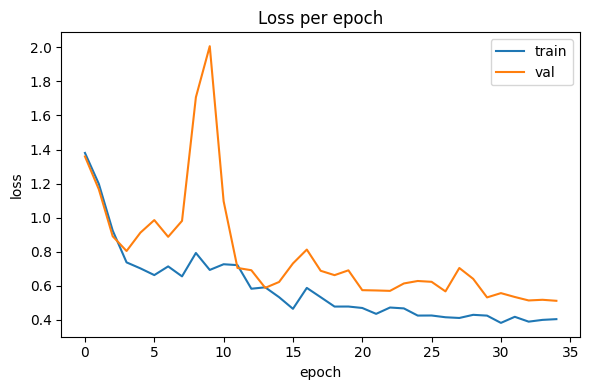

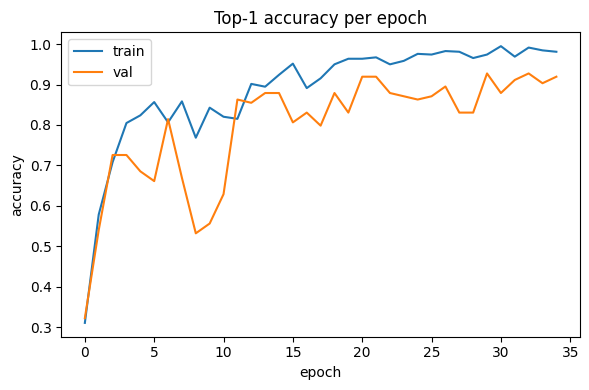

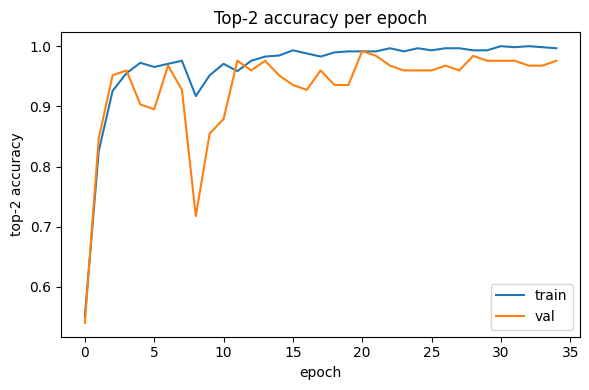

In [19]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_loss"], label="train")
plt.plot(history_crop["val_loss"],   label="val")
plt.title("Loss per epoch"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

# Accuracy (top-1)
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_acc"], label="train")
plt.plot(history_crop["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# Top-2
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_top2"], label="train")
plt.plot(history_crop["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# LR schedule across batches (OneCycle)
if history_crop["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history_crop["lrs"])
    plt.title("Learning rate (per batch)"); plt.xlabel("batch"); plt.ylabel("lr")
    plt.tight_layout(); plt.show()


El análisis de los gráficos de desempeño permite entender cómo evolucionó el aprendizaje del modelo a lo largo del entrenamiento. En primer lugar, se observa una disminución progresiva de la pérdida (loss) tanto en entrenamiento como en validación, lo que indica que el modelo fue capaz de ajustar sus parámetros de manera efectiva para minimizar el error. Sin embargo, a partir de cierto punto, la pérdida en validación deja de disminuir con la misma consistencia, manteniéndose en un rango estable mientras que la de entrenamiento continúa bajando. Esto sugiere que el modelo comenzó a memorizar mejor los datos de entrenamiento que los de validación, un indicio leve de sobreajuste común en escenarios con conjuntos de datos limitados.

Por otro lado, las métricas de precisión reflejan un comportamiento sólido. La top-1 accuracy alcanza rápidamente valores altos y se mantiene por encima del 85 % en validación, aunque sin mejoras significativas después de las primeras épocas, lo que refuerza la idea de que el modelo converge pronto. La top-2 accuracy presenta resultados aún más destacados, rozando el 100 %, lo que implica que el modelo suele incluir la clase correcta dentro de sus dos predicciones más probables. Este comportamiento es valioso en contextos clínicos, donde reducir falsos negativos es prioritario y puede aceptarse cierta ambigüedad mientras la clase correcta esté entre las opciones principales. En conjunto, los gráficos evidencian un modelo bien entrenado, con buena capacidad de generalización y solo un nivel moderado de sobreajuste (ya tratado con una leve aumentación de los datos), adecuado como un primer modelo o baseline para abordar el problema en cuestión.

### Evaluación

In [20]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 0) Carga el mejor modelo
model.load_state_dict(torch.load("best.pt", map_location=device))
model.to(device).eval()

criterion = torch.nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test:   # dl_test debe entregar tensores normalizados igual que train/val
        xb = xb.to(device, non_blocking=True)    # yb se queda en CPU; está bien para sklearn
        logits = model(xb)                       # (B, C)

        # acumular para métricas globales
        all_logits.append(logits.cpu())
        all_targets.append(yb)

        # loss y top-k
        loss = criterion(logits.cpu(), yb)       # logits a CPU para usar el mismo yb
        test_loss += loss.item() * xb.size(0)
        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()
        _, top2 = logits.topk(2, dim=1)          # en device
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()
        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

# Ajusta el orden/nombres según tu label encoder
# Por ejemplo, si usaste este orden en el fit: ["ASD","Normal","PDA","VSD"]
target_names = ["ASD","Normal","PDA","VSD"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-443909943.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 0.399591796875, 'acc': 0.872, 'top2': 0.944}
              precision    recall  f1-score   support

         ASD     0.7895    0.9375    0.8571        32
      Normal     0.8750    0.7241    0.7925        29
         PDA     0.8611    0.9394    0.8986        33
         VSD     1.0000    0.8710    0.9310        31

    accuracy                         0.8720       125
   macro avg     0.8814    0.8680    0.8698       125
weighted avg     0.8804    0.8720    0.8714       125

[[30  1  1  0]
 [ 6 21  2  0]
 [ 1  1 31  0]
 [ 1  1  2 27]]


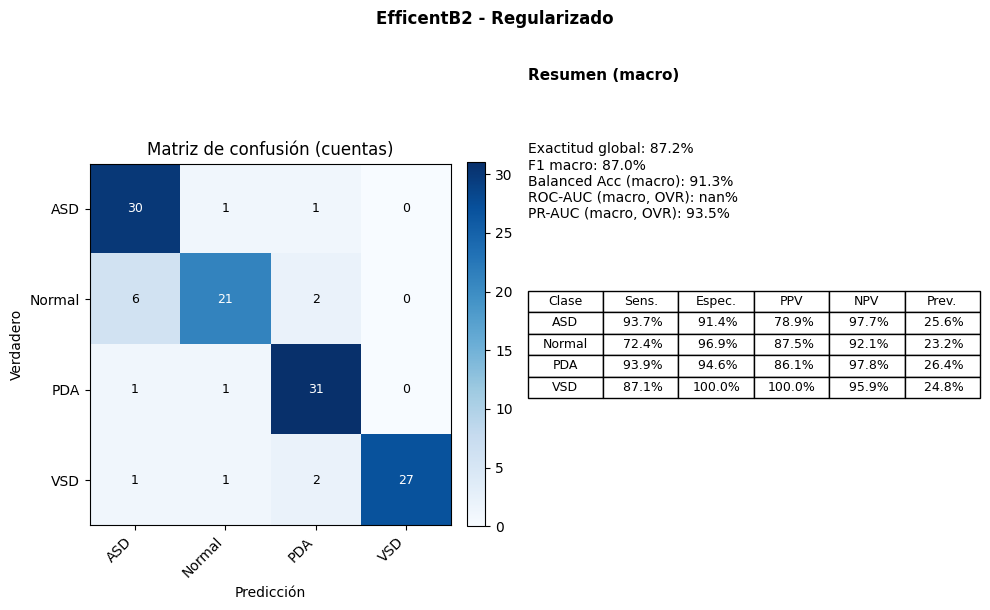

In [22]:
metrics, fig = eval_multiclase(y_true, y_pred, y_prob, target_names, titulo="EfficentB2 - Regularizado")

### Diferencia entre modelo regularizado y modelo base


| Clase   | Δ Sens. | Δ Espec. | Δ PPV  | Δ NPV  |
|---------|--------:|---------:|-------:|-------:|
| ASD     |   0.0%  |  -1.1%   |  -2.2% |   0.0% |
| Normal  |  +3.4%  |   0.0%   |  +0.5% |  +0.9% |
| PDA     |  +3.0%  |  -1.1%   |  -2.1% |  +1.1% |
| VSD     |  +3.2%  |  +5.3%   | +16.1% |  +1.2% |

* El mayor salto ocurre en la clase VSD, con un aumento muy significativo del PPV (+16.1%) y una especificidad perfecta.
* La clase Normal mejora ligeramente en sensibilidad (+3.4%) y NPV (+0.9%), lo que indica menos falsos negativos.
* PDA y ASD mantienen sensibilidades altas, aunque hay pequeñas caídas en especificidad y PPV.

## DenseNet

Ajustes:



*   Se mantienen los valores para LR y weight decay, ya que las alteraciones probadas disminuyen el rendimiento en la mayoría de las métricas.
* Se incrementan las capas a 201 en lugar de 201.
* Se incrementa el número de épocas a 50 en lugar de 25.





### Implementación

In [61]:
history_crop = {
    "train_loss": [], "train_acc": [], "train_top2": [],
    "val_loss":   [], "val_acc":   [], "val_top2":   [],
    "lrs": []  # per-batch LR track (for OneCycle)
}

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Datos: X_*_normalized (N,320,320,1) en [0,1]; Y_*_encoded one-hot (N,4)
num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

# Normalización por dataset (rápida): media y std del canal gris
def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

# vit_weights = models.ViT_B_16_Weights.IMAGENET1K_V1
# vit_preprocess = vit_weights.transforms()

d121_weights = DenseNet201_Weights.IMAGENET1K_V1
d121_preprocess = d121_weights.transforms()  # Resize(224), ToTensor, Normalize ImageNet

train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Necesario para que las transformaciones de PIL funcionen
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)), # Rotación de +/- 10 grados, traslación del 5%
    d121_preprocess # Convierte de nuevo a tensor
])

# Transformaciones para validación/prueba
# No queremos aumentar estos datos para tener una evaluación consistente
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    d121_preprocess
])


class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, transform=None):
        self.x = x_nhwc.astype(np.uint8)      # (N,H,W,1) en 0-255
        self.y = y_idx.astype(np.int64)
        self.transform = transform

    def __len__(self): return self.x.shape[0]

    def __getitem__(self, i):
        img = self.x[i]                        # (H,W,1)
        if self.transform is not None:
            img = self.transform(img)          # -> (3,224,224) float normalizado
        else:
            # fallback mínimo si hicieras inferencia sin transform
            img = torch.from_numpy(np.transpose(img, (2,0,1))).float() / 255.0
            img = img.repeat(3, 1, 1)         # a 3 canales
        return img, torch.tensor(self.y[i])


X_train_uint8 = (X_train_normalized * 255).astype(np.uint8)
X_val_uint8 = (X_val_normalized * 255).astype(np.uint8)
X_test_uint8 = (X_test_normalized * 255).astype(np.uint8)

BATCH = 64
train_dataset = NumpyGrayDataset(X_train_uint8, y_train_idx, transform=train_transforms)
val_dataset = NumpyGrayDataset(X_val_uint8, y_val_idx, transform=val_test_transforms)
test_dataset = NumpyGrayDataset(X_test_uint8, y_test_idx, transform=val_test_transforms)

dl_train = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
dl_val = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)


class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        weights = d121_weights if pretrained else None
        m = models.densenet201(weights=weights)
        # Ya entran 3 canales por tus transforms; no hay que tocar la primera conv
        m.classifier = nn.Linear(m.classifier.in_features, num_classes)
        self.net = m
    def forward(self, x):
        return self.net(x)


model = DenseNetClassifier(num_classes).to(device)

# ---- Pérdida con label smoothing + optimizer + OneCycle ----
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
EPOCHS = 50
steps_per_epoch = len(dl_train)
scheduler = OneCycleLR(optimizer, max_lr=5e-4, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)

scaler = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = total = a1 = a2 = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
        bs = xb.size(0)
        total_loss += loss.item()*bs; total += bs
        a1 += topk_acc(logits, yb, 1)*bs; a2 += topk_acc(logits, yb, 2)*bs
    return total_loss/total, a1/total, a2/total

best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch(dl_train, train=True)
    va_loss, va_a1, va_a2 = run_epoch(dl_val,   train=False)

    history_crop["train_loss"].append(tr_loss); history_crop["train_acc"].append(tr_a1); history_crop["train_top2"].append(tr_a2)
    history_crop["val_loss"].append(va_loss);   history_crop["val_acc"].append(va_a1);   history_crop["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer.param_groups[0]['lr']:.2e}")

    # Always save the best checkpoint
    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model.state_dict(), "best.pt")

# Save the last epoch
torch.save(model.state_dict(), "last.pt")


Device: cuda
Dataset norm: mean=0.6007, std=0.1668


/tmp/ipython-input-1573279601.py:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1573279601.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1573279601.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


Epoch 01 | train 1.3530 acc 0.332 top2 0.615 | val 1.3407 acc 0.355 top2 0.556 | lr 3.20e-05
Epoch 02 | train 1.1902 acc 0.573 top2 0.807 | val 1.2073 acc 0.435 top2 0.710 | lr 6.67e-05
Epoch 03 | train 1.0119 acc 0.620 top2 0.872 | val 1.1342 acc 0.556 top2 0.774 | lr 1.21e-04
Epoch 04 | train 0.8588 acc 0.722 top2 0.905 | val 1.1520 acc 0.468 top2 0.782 | lr 1.89e-04
Epoch 05 | train 0.6950 acc 0.832 top2 0.965 | val 0.9240 acc 0.677 top2 0.895 | lr 2.64e-04
Epoch 06 | train 0.6511 acc 0.853 top2 0.972 | val 3.6280 acc 0.355 top2 0.540 | lr 3.38e-04
Epoch 07 | train 0.7088 acc 0.803 top2 0.959 | val 2.5078 acc 0.476 top2 0.887 | lr 4.05e-04
Epoch 08 | train 0.8275 acc 0.737 top2 0.936 | val 1.6088 acc 0.387 top2 0.742 | lr 4.58e-04
Epoch 09 | train 0.7351 acc 0.800 top2 0.965 | val 1.3174 acc 0.492 top2 0.782 | lr 4.90e-04
Epoch 10 | train 0.7458 acc 0.810 top2 0.953 | val 0.9677 acc 0.629 top2 0.871 | lr 5.00e-04
Epoch 11 | train 0.6083 acc 0.896 top2 0.976 | val 3.2466 acc 0.387 to

### Desempeño en entrenamiento

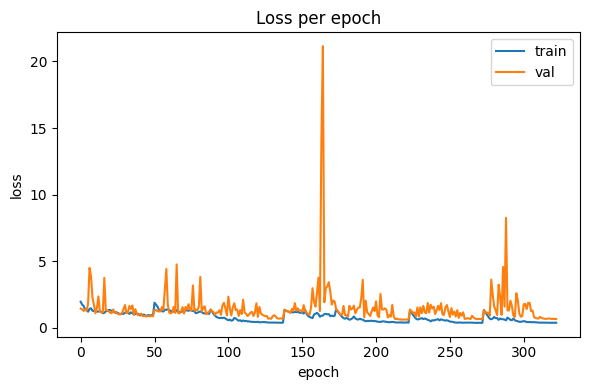

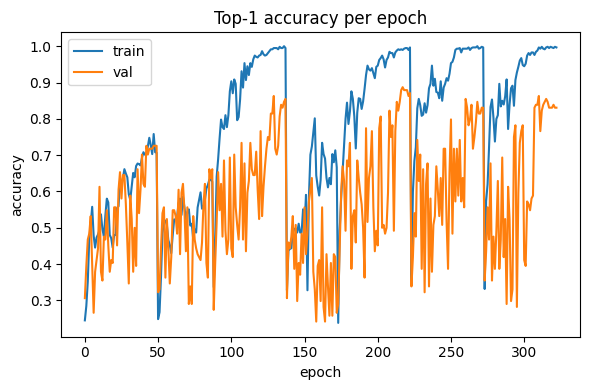

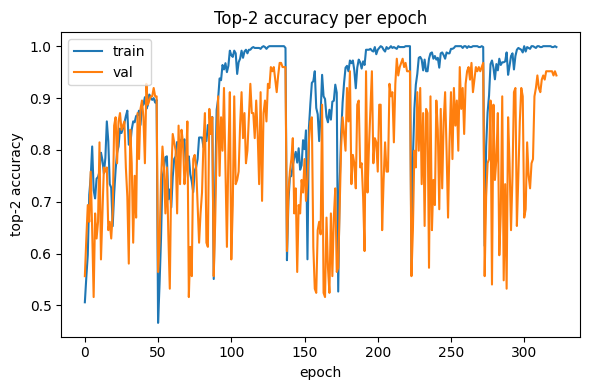

In [86]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_loss"], label="train")
plt.plot(history_crop["val_loss"],   label="val")
plt.title("Loss per epoch"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

# Accuracy (top-1)
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_acc"], label="train")
plt.plot(history_crop["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# Top-2
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_top2"], label="train")
plt.plot(history_crop["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# LR schedule across batches (OneCycle)
if history_crop["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history_crop["lrs"])
    plt.title("Learning rate (per batch)"); plt.xlabel("batch"); plt.ylabel("lr")
    plt.tight_layout(); plt.show()

### Evaluación

In [87]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 0) Carga el mejor modelo
model.load_state_dict(torch.load("best.pt", map_location=device))
model.to(device).eval()

criterion = torch.nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test:   # dl_test debe entregar tensores normalizados igual que train/val
        xb = xb.to(device, non_blocking=True)    # yb se queda en CPU; está bien para sklearn
        logits = model(xb)                       # (B, C)

        # acumular para métricas globales
        all_logits.append(logits.cpu())
        all_targets.append(yb)

        # loss y top-k
        loss = criterion(logits.cpu(), yb)       # logits a CPU para usar el mismo yb
        test_loss += loss.item() * xb.size(0)
        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()
        _, top2 = logits.topk(2, dim=1)          # en device
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()
        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

# Ajustar el orden/nombres según label encoder
target_names = ["ASD","Normal","PDA","VSD"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-1348575209.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 0.470123046875, 'acc': 0.848, 'top2': 0.952}
              precision    recall  f1-score   support

         ASD     0.7750    0.9688    0.8611        32
      Normal     0.8077    0.7241    0.7636        29
         PDA     0.9667    0.8788    0.9206        33
         VSD     0.8621    0.8065    0.8333        31

    accuracy                         0.8480       125
   macro avg     0.8529    0.8445    0.8447       125
weighted avg     0.8548    0.8480    0.8473       125

[[31  1  0  0]
 [ 7 21  0  1]
 [ 0  1 29  3]
 [ 2  3  1 25]]


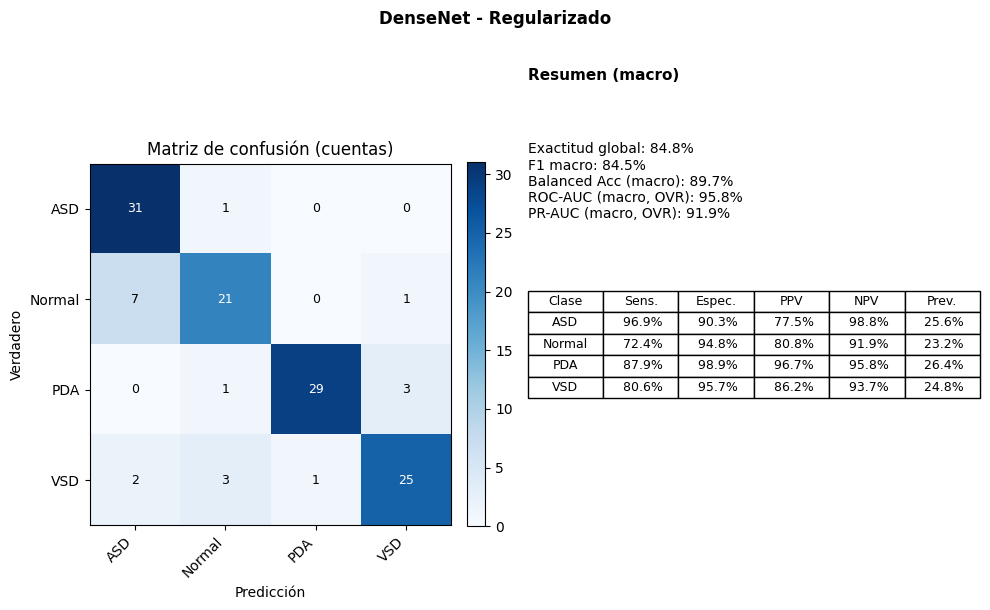

In [88]:
metrics, fig = eval_multiclase(y_true, y_pred, y_prob, target_names, titulo="DenseNet - Regularizado")

### Diferencia entre DenseNet regularizado y DenseNet base



| Clase   | Δ Sens. | Δ Espec. | Δ PPV  | Δ NPV  |
|---------|--------:|---------:|-------:|-------:|
| ASD     |  +3.2%  |  +1.1%   |  +2.5% |  +1.2% |
| Normal  |  +3.4%  |  -1.0%   |  -2.5% |  +0.8% |
| PDA     |   0.0%  |  +3.2%   |  +8.8% |  +0.1% |
| VSD     |  +3.2%  |   0.0%   |  +0.5% |  +0.9% |


* La sensibilidad mejora de forma consistente en todas las clases, especialmente en ASD y VSD (+3.2%).
* La especificidad y el PPV presentan ganancias importantes en ASD y PDA (+3.2% y +8.8%, respectivamente), lo que indica menos falsos positivos.
* La clase Normal mejora en sensibilidad y NPV, aunque pierde ligeramente en especificidad y PPV, sugiriendo un mayor enfoque del modelo en reducir falsos negativos.

## Referencias

1. Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2021). *An image is worth 16x16 words: Transformers for image recognition at scale*. International Conference on Learning Representations (ICLR). https://arxiv.org/abs/2010.11929

2. Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). *Densely connected convolutional networks*. In *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)* (pp. 4700–4708). https://doi.org/10.1109/CVPR.2017.243

3. Liu, Z., Lin, Y., Cao, Y., Hu, H., Wei, Y., Zhang, Z., ... & Guo, B. (2021). *Swin Transformer: Hierarchical vision transformer using shifted windows*. In *Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV)* (pp. 10012–10022). https://doi.org/10.1109/ICCV48922.2021.00986

4. Tan, M., & Le, Q. V. (2021). *EfficientNetV2: Smaller models and faster training*. In *Proceedings of the 38th International Conference on Machine Learning (ICML)* (pp. 10096–10106). https://arxiv.org/abs/2104.00298

5. Liu, Z., Mao, H., Wu, C. Y., Feichtenhofer, C., Darrell, T., & Xie, S. (2022). *ConvNeXt: Revisiting convnets for image recognition*. In *Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)* (pp. 12527–12536). https://doi.org/10.1109/CVPR52688.2022.01220

6. He, K., Zhang, X., Ren, S., & Sun, J. (2016). *Deep residual learning for image recognition*. In *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)* (pp. 770–778). https://doi.org/10.1109/CVPR.2016.90
